- Investigate 1st and 2nd order differences in cases and deaths $x$ days after some policy was implemented

In [1]:

import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
import numpy as np
from covid_project import data_cleaning as dc
from covid_project.diffs import calculate_diffs, generate_state_case_dict
from tqdm.notebook import tqdm
import warnings
import matplotlib.pyplot as plt
import os
from scipy.stats import t

Uncomment the cell below and run this script if running this project from scratch (should take about 30 minutes)

In [2]:
# !python scripts/differencing.py

Build a master dataset of all diffs

In [3]:
dfs = []

for e in os.listdir("./data/diffs/"):
    lag = int(e.split('_')[0])
    df = pd.read_csv(os.path.join("data", "diffs", e), index_col=0)
    df['lag'] = lag
    df = df.rename(
        {f"case_{lag}_day_order_1": "case_order_1",
         f"case_{lag}_day_order_2": "case_order_2",
         f"death_{lag}_day_order_1": "death_order_1",
         f"death_{lag}_day_order_2": "death_order_2"},
        axis=1)
    dfs.append(df)

diffs_df = pd.concat(dfs)

In [4]:
diffs_df

state policy_level        date               policy_type  \
1       Mississippi       county  2020-07-20    outdoor and recreation   
3          Missouri        state  2020-06-15  non-essential businesses   
5           Georgia       county  2020-04-30          childcare (k-12)   
6          Missouri       county  2020-05-31             entertainment   
7          Missouri        state  2021-08-31          mask requirement   
...             ...          ...         ...                       ...   
4213       Illinois       county  2021-01-15         houses of worship   
4214       New York       county  2020-06-08  non-essential businesses   
4215          Texas       county  2020-07-03          mask requirement   
4216          Maine       county  2020-05-18    outdoor and recreation   
4217  West Virginia        state  2020-03-19            food and drink   

     start_stop       county  fips_code  case_order_1  case_order_2  \
1          stop    sunflower      28133      2.148349      0.477411   
3          stop    statewide         29      4.587782      0.104569   
5          stop       fulton      13121      1.146881      0.122647   
6          stop      jackson      29095     -0.356935      0.051220   
7          stop    statewide         29     -9.513745      0.653029   
...         ...          ...        ...           ...           ...   
4213      start         cass      17017    -29.372286     -0.308653   
4214      start     new york      36061     -0.341199      0.004733   
4215      start       morris      48343      1.207341     -0.106100   
4216      start  piscataquis      23021      0.000000      0.000000   
4217      start    statewide         54      5.411877     -0.005850   

      death_order_1  death_order_2  lag  
1          0.527665       0.238705    9  
3         -0.363323      -0.007241    9  
5         -0.097857       0.000109    9  
6         -0.062138       0.000000    9  
7          0.025157      -0.012125    9  
...             ...            ...  ...  
4213       0.000000       0.000000   22  
4214      -0.255440      -0.003146   22  
4215       0.000000       0.000000   22  
4216       0.000000       0.000000   22  
4217       0.018494       0.000000   22  

[94822 rows x 12 columns]

Do some crunching on the deltas to calculate some bounds

In [16]:
def calculate_ci(mean, std, n):
    t_value = t.ppf(1 - 0.025, n - 1)
    margin_of_error = t_value * (std / np.sqrt(n))
    return mean - margin_of_error, mean + margin_of_error
    
stats = []
# counts = diffs_df['policy_type'].value_counts()
# unique_policies = counts[counts > 5].index
unique_policies = diffs_df['policy_type'].unique()

for policy in unique_policies:
    for start_stop in ['start', 'stop']:
        policy_rows = diffs_df[
            (diffs_df['policy_type'] == policy) &\
            (diffs_df['start_stop'] == start_stop)
        ]
        
        for l in policy_rows['lag'].unique():
            tmp = policy_rows[policy_rows['lag'] == l]
            sample_size = len(tmp)

            if sample_size > 5:  # Ensure there are enough samples to calculate CI
                case_1st_order_mean = tmp['case_order_1'].mean()
                case_1st_order_std = tmp['case_order_1'].std()
                case_1st_order_ci_lower, case_1st_order_ci_upper = calculate_ci(case_1st_order_mean, case_1st_order_std, sample_size)

                case_2nd_order_mean = tmp['case_order_2'].mean()
                case_2nd_order_std = tmp['case_order_2'].std()
                case_2nd_order_ci_lower, case_2nd_order_ci_upper = calculate_ci(case_2nd_order_mean, case_2nd_order_std, sample_size)

                death_1st_order_mean = tmp['death_order_1'].mean()
                death_1st_order_std = tmp['death_order_1'].std()
                death_1st_order_ci_lower, death_1st_order_ci_upper = calculate_ci(death_1st_order_mean, death_1st_order_std, sample_size)

                death_2nd_order_mean = tmp['death_order_2'].mean()
                death_2nd_order_std = tmp['death_order_2'].std()
                death_2nd_order_ci_lower, death_2nd_order_ci_upper = calculate_ci(death_2nd_order_mean, death_2nd_order_std, sample_size)

                stats.append({
                    'lag': l,
                    'policy': policy,
                    'start_stop': start_stop,
                    'full_policy': policy + " - " + start_stop,
                    'case_1st_order_mean': case_1st_order_mean,
                    'case_1st_order_std': case_1st_order_std,
                    'case_1st_order_ci_lower': case_1st_order_ci_lower,
                    'case_1st_order_ci_upper': case_1st_order_ci_upper,
                    'case_2nd_order_mean': case_2nd_order_mean,
                    'case_2nd_order_std': case_2nd_order_std,
                    'case_2nd_order_ci_lower': case_2nd_order_ci_lower,
                    'case_2nd_order_ci_upper': case_2nd_order_ci_upper,
                    'death_1st_order_mean': death_1st_order_mean,
                    'death_1st_order_std': death_1st_order_std,
                    'death_1st_order_ci_lower': death_1st_order_ci_lower,
                    'death_1st_order_ci_upper': death_1st_order_ci_upper,
                    'death_2nd_order_mean': death_2nd_order_mean,
                    'death_2nd_order_std': death_2nd_order_std,
                    'death_2nd_order_ci_lower': death_2nd_order_ci_lower,
                    'death_2nd_order_ci_upper': death_2nd_order_ci_upper,
                    'sample_size': sample_size
                })

stats = pd.DataFrame(stats).sort_values(by='lag')

/tmp/ipykernel_28963/3906727299.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))


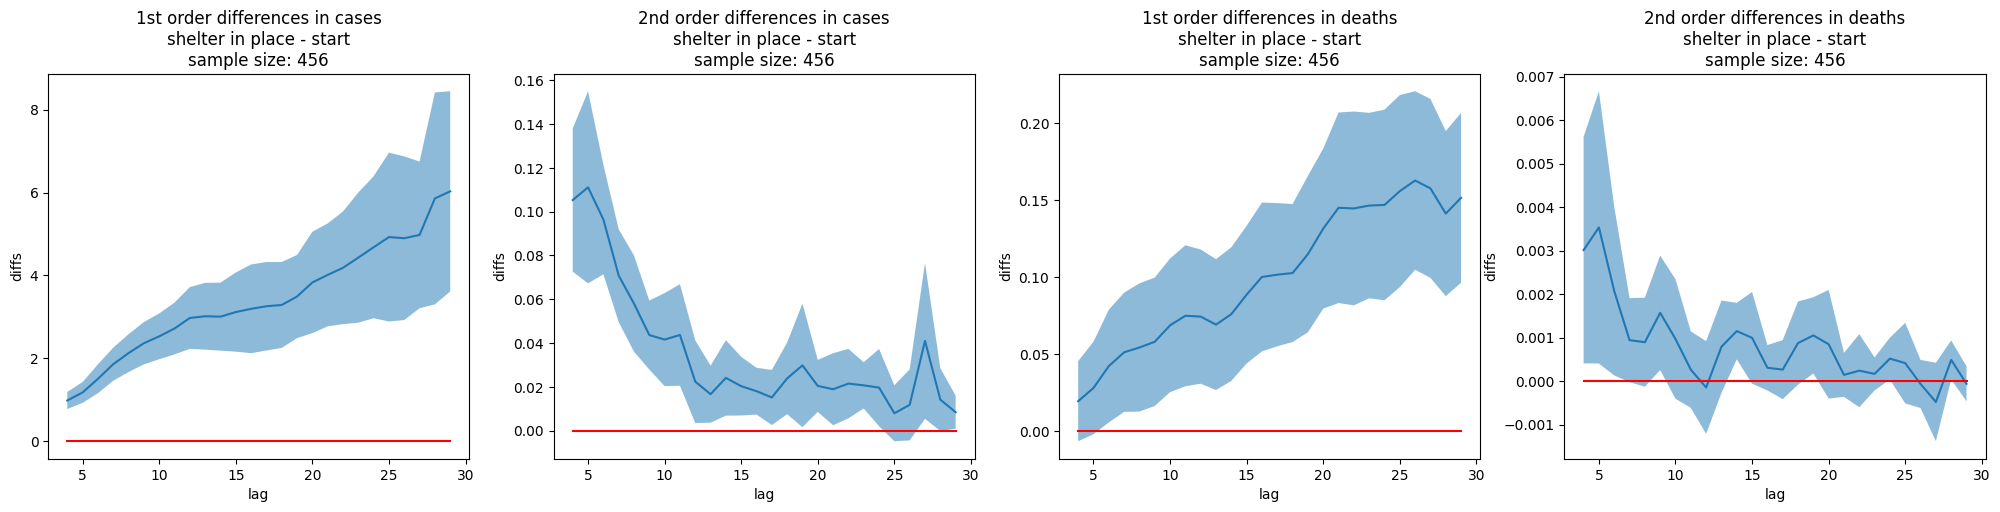

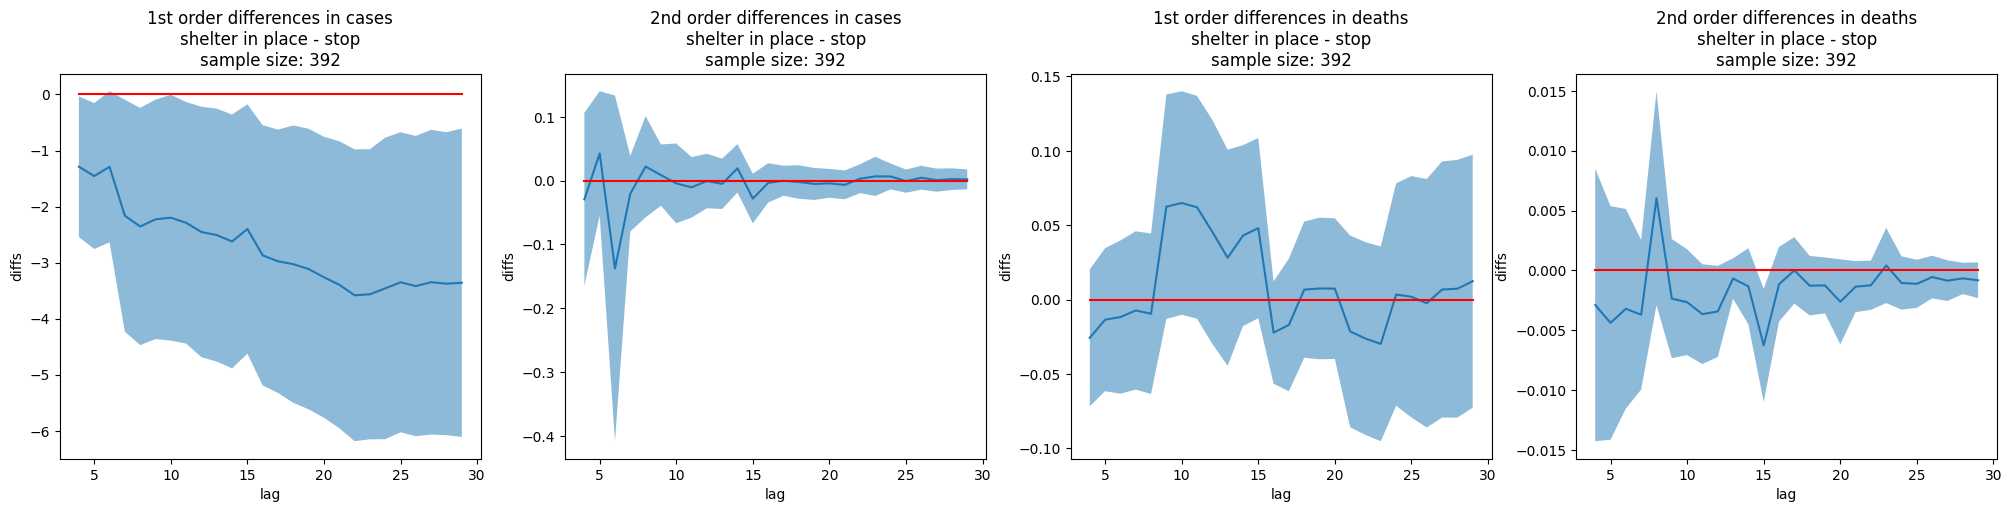

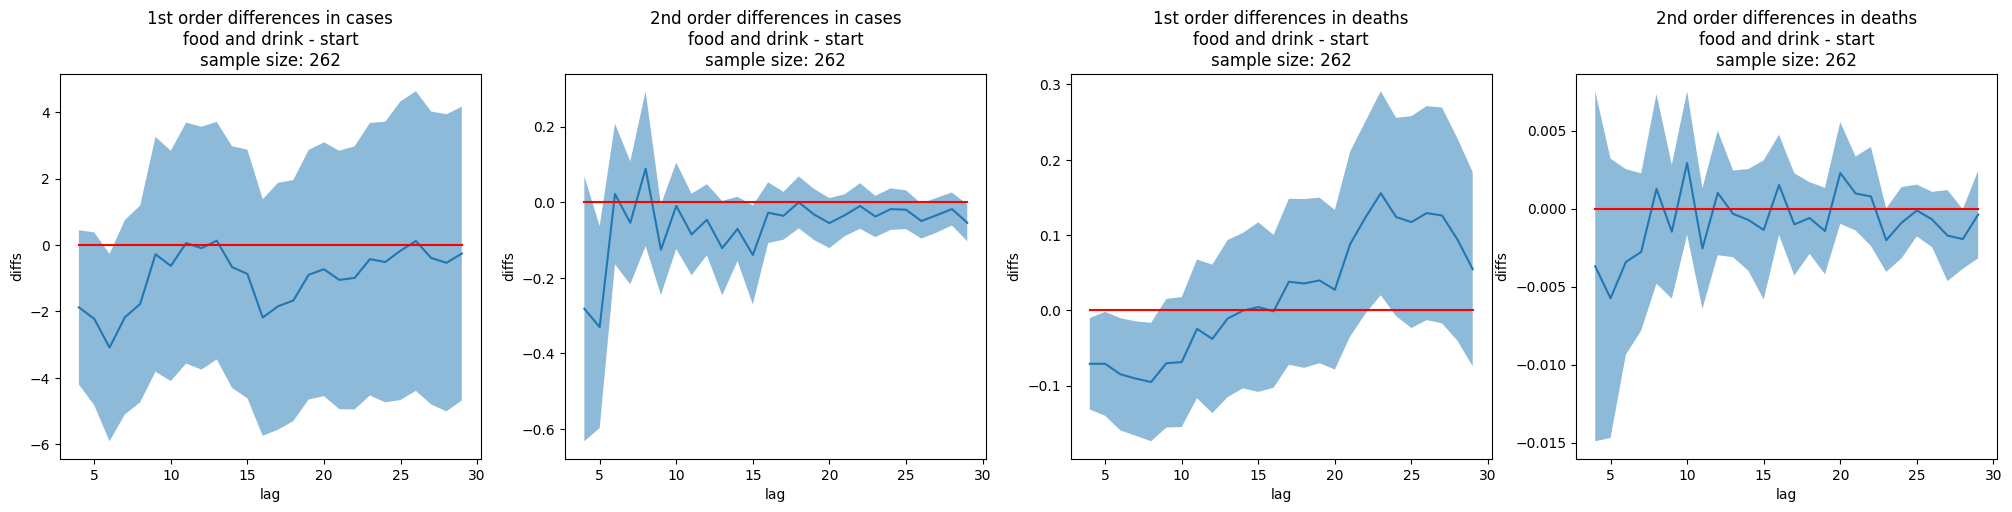

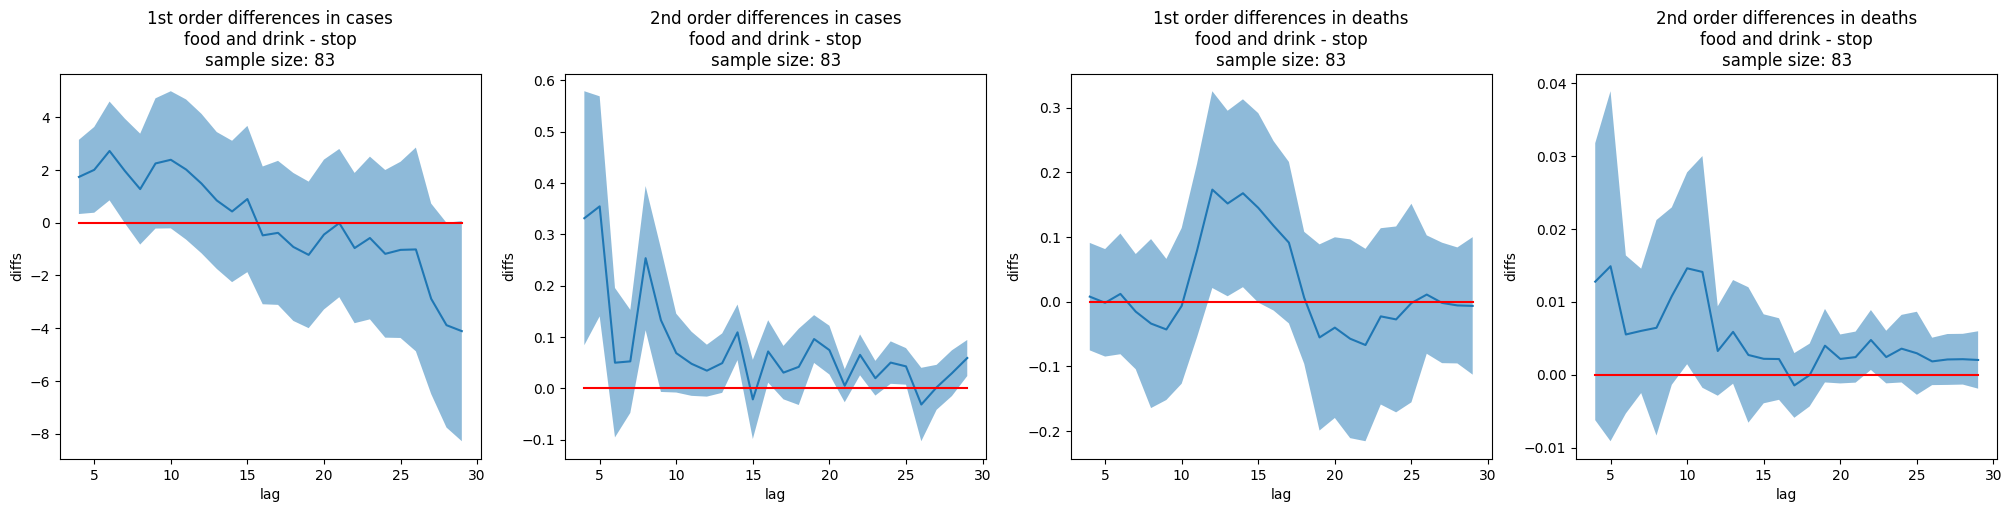

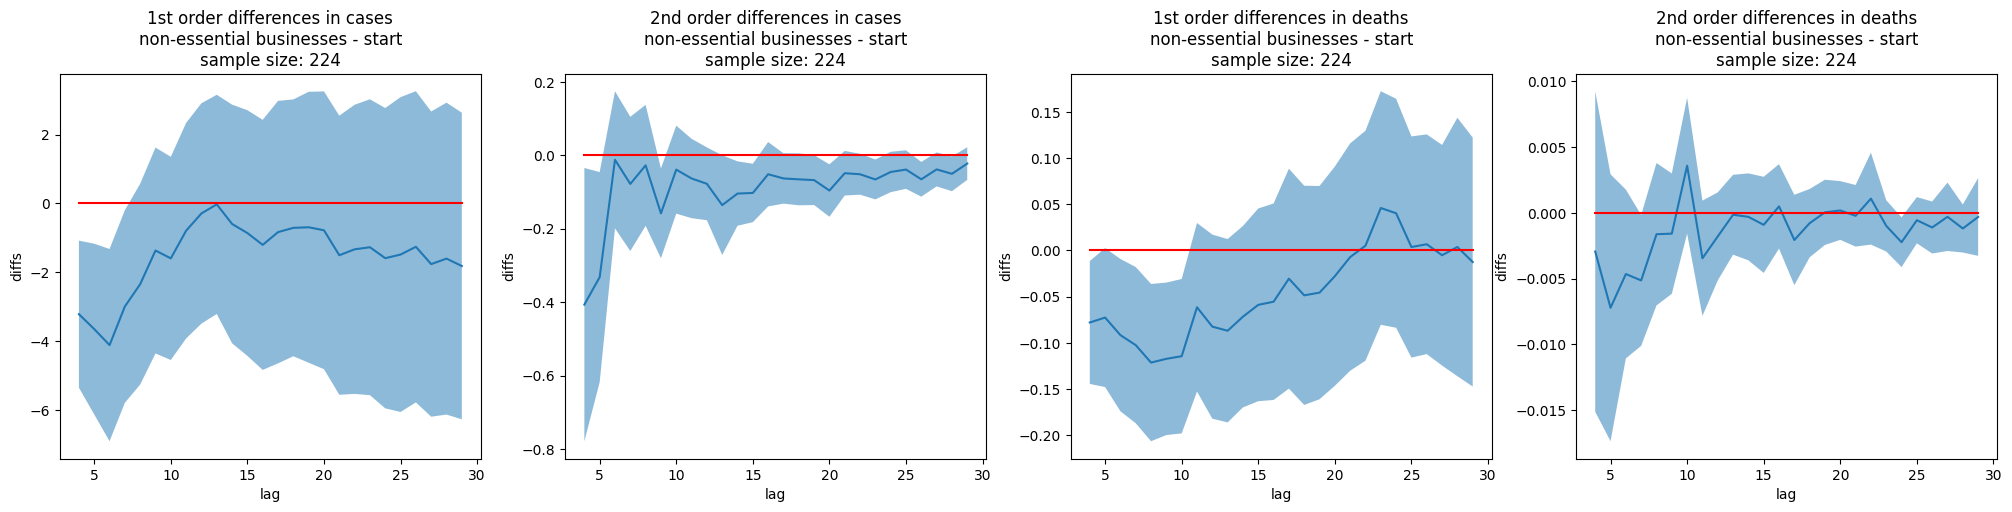

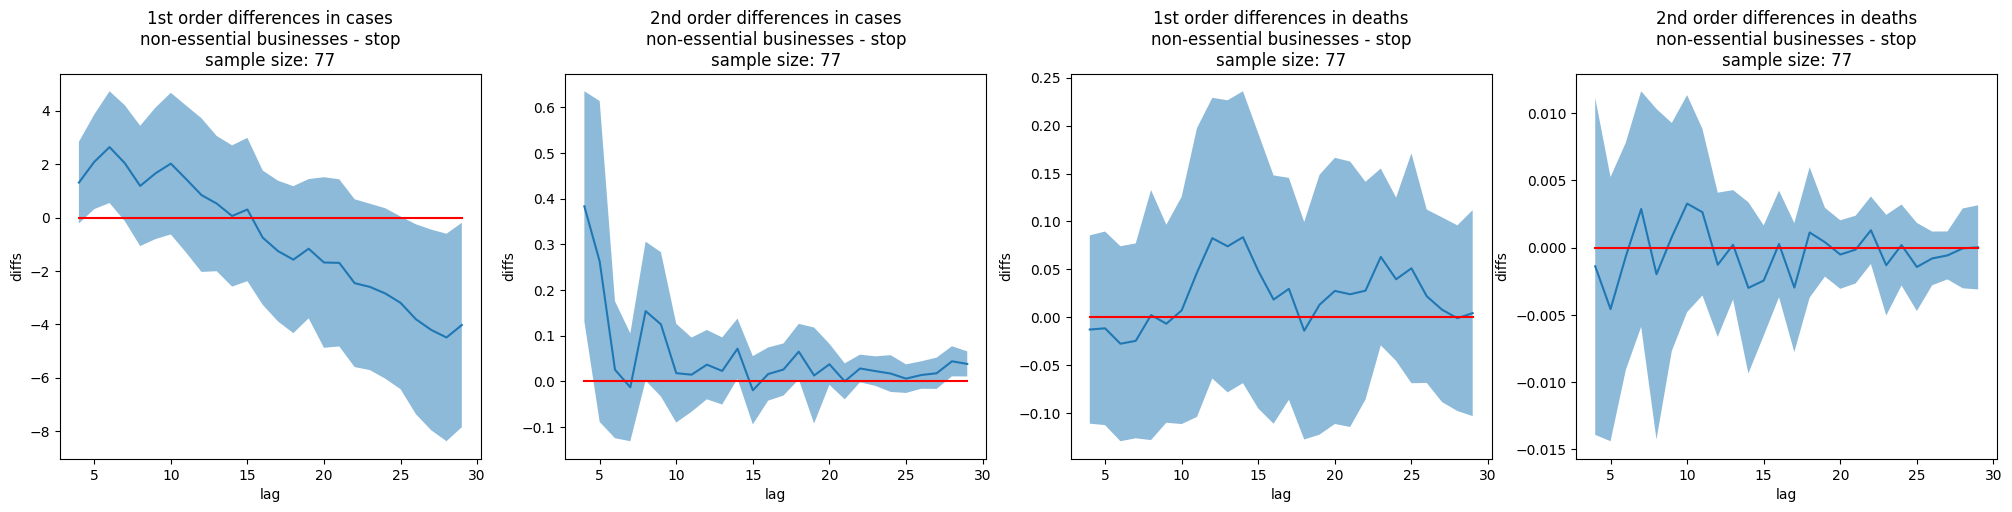

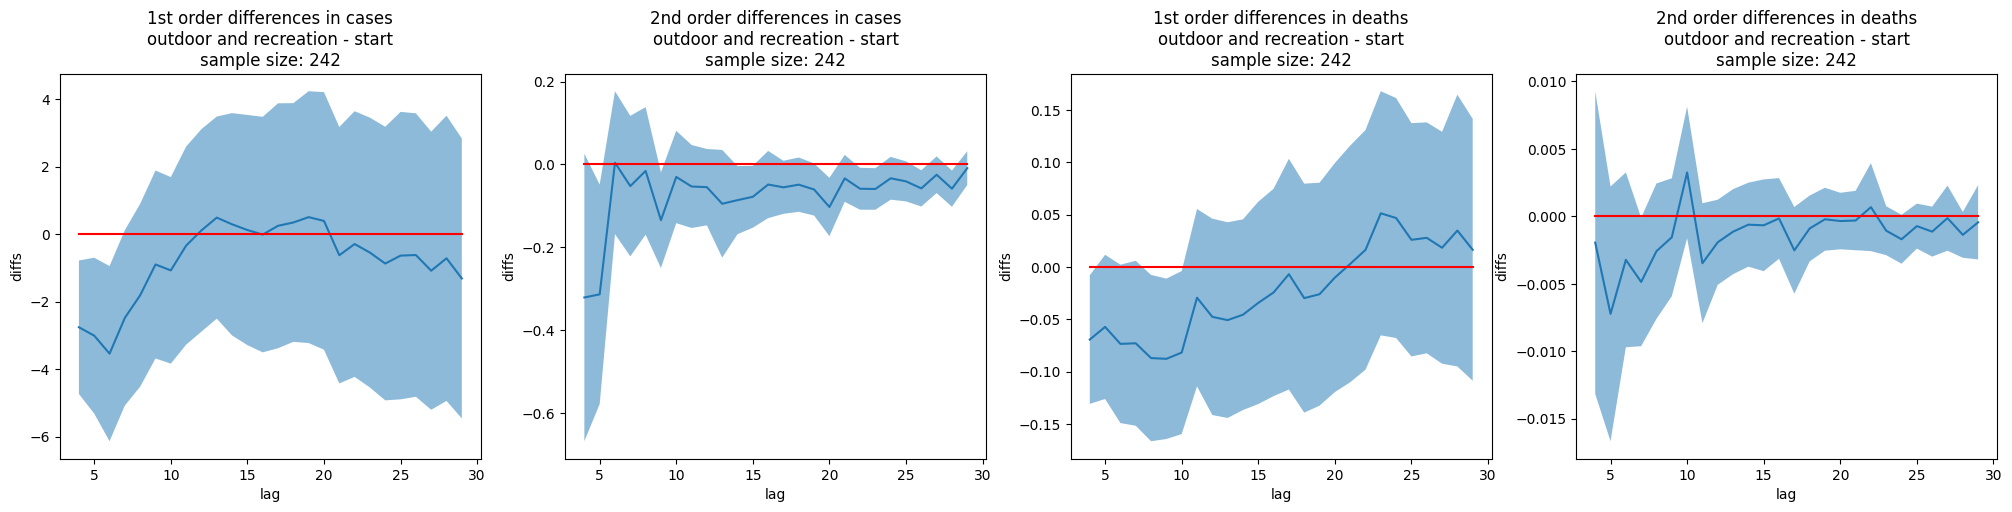

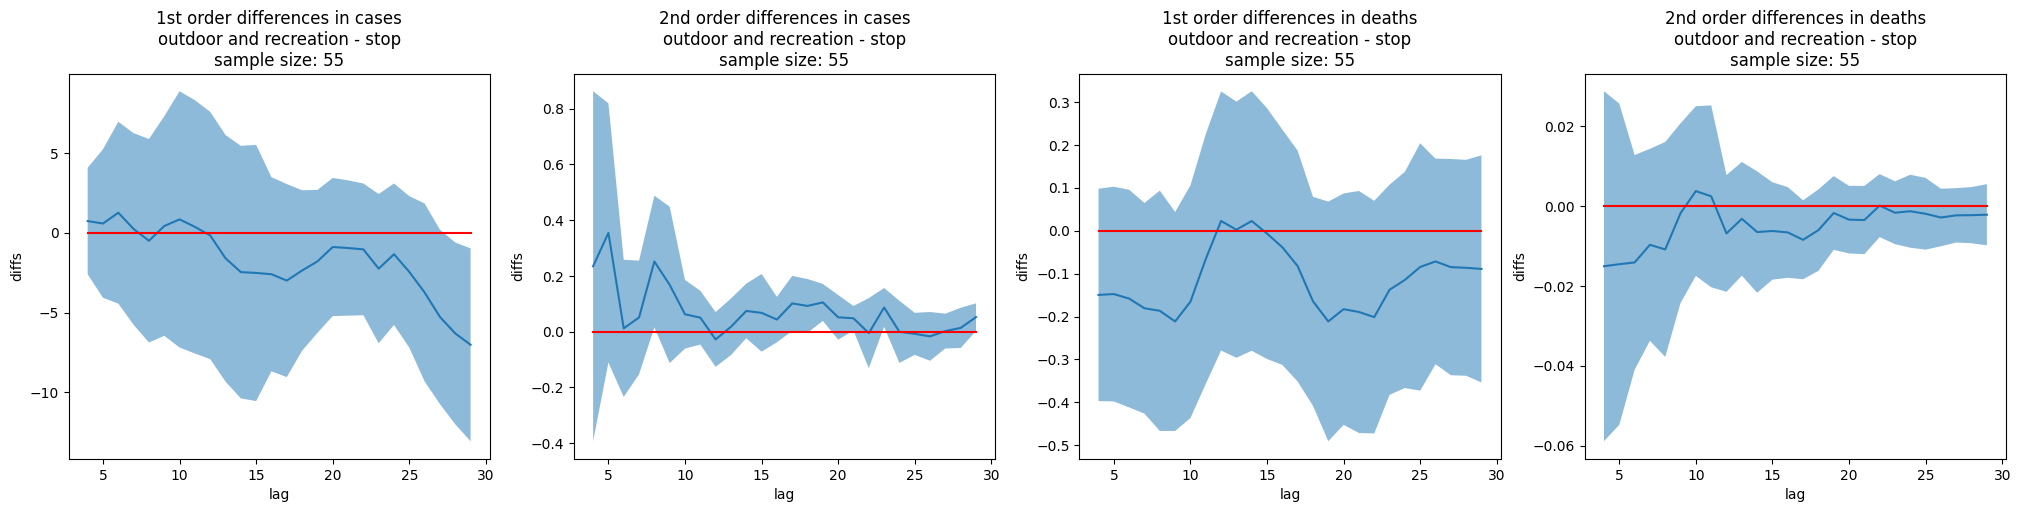

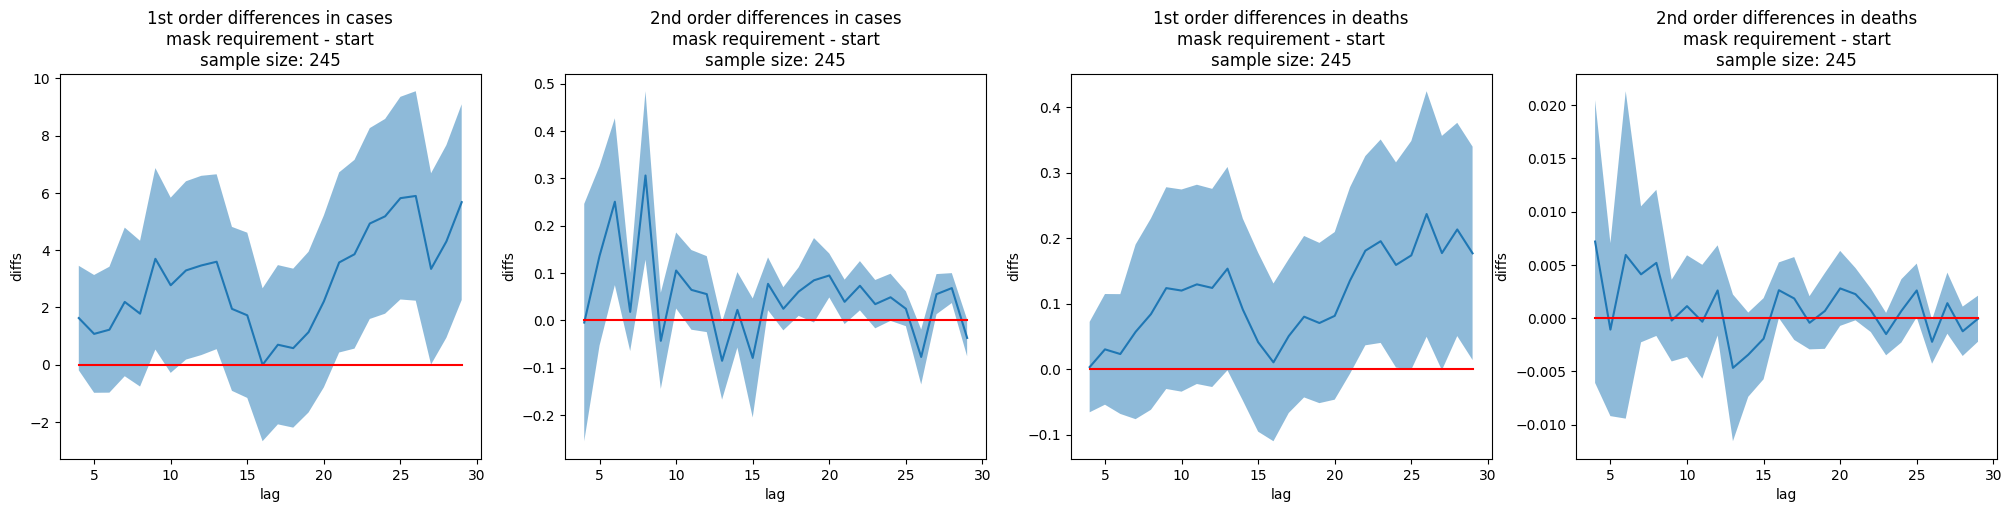

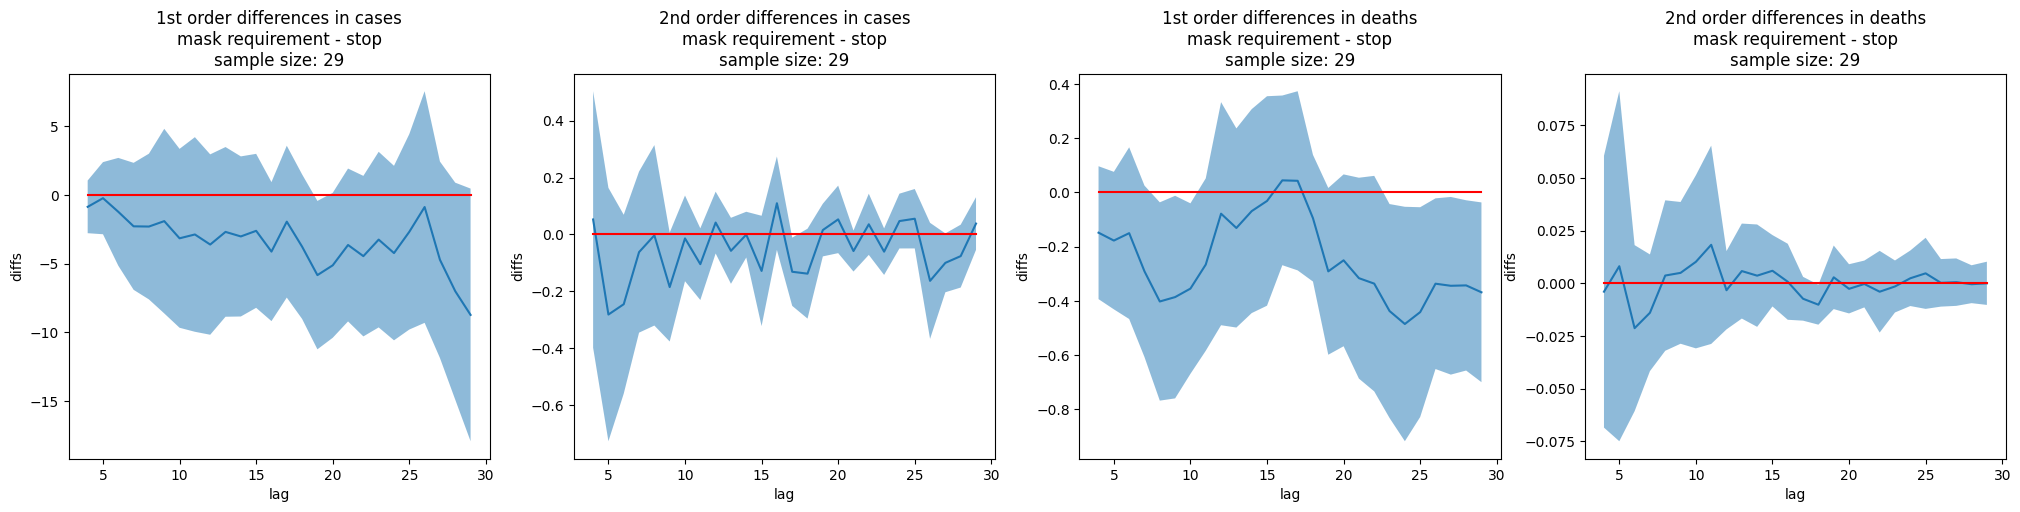

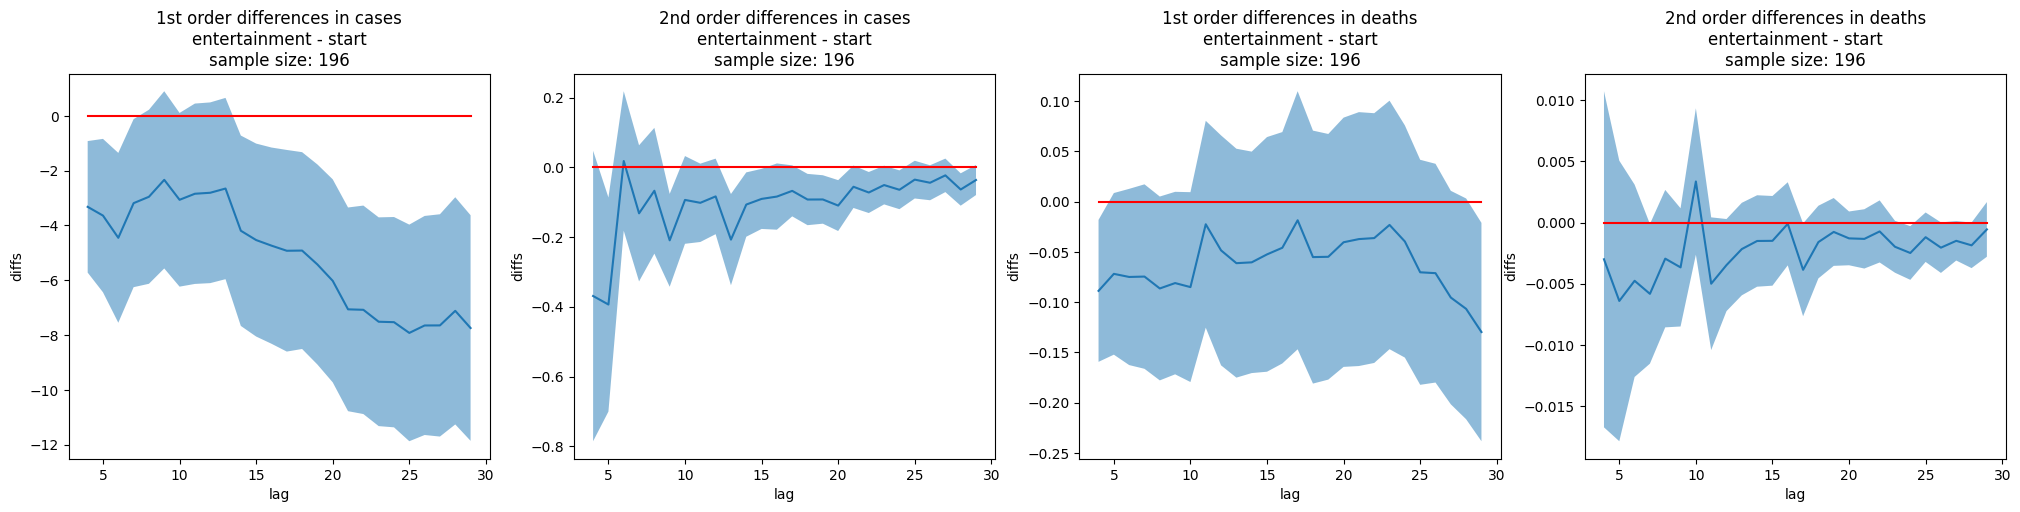

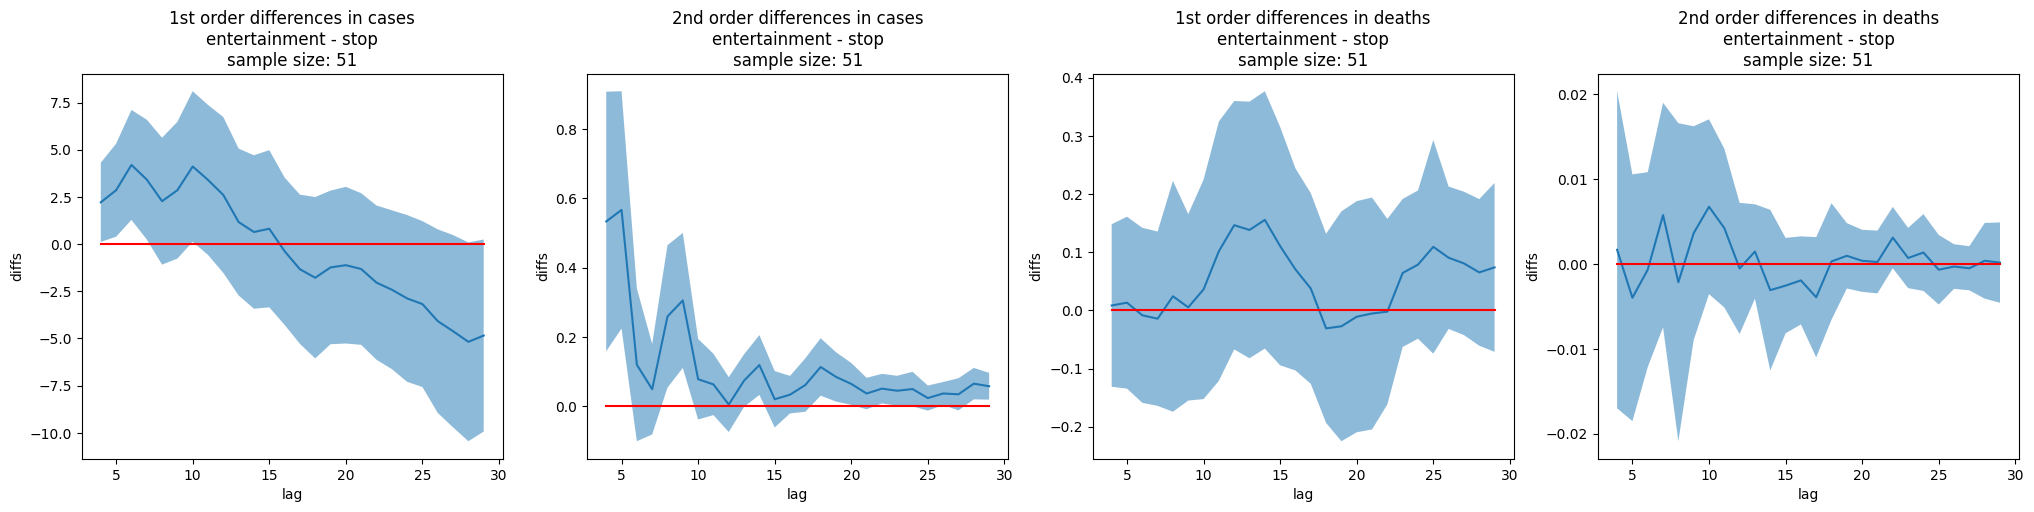

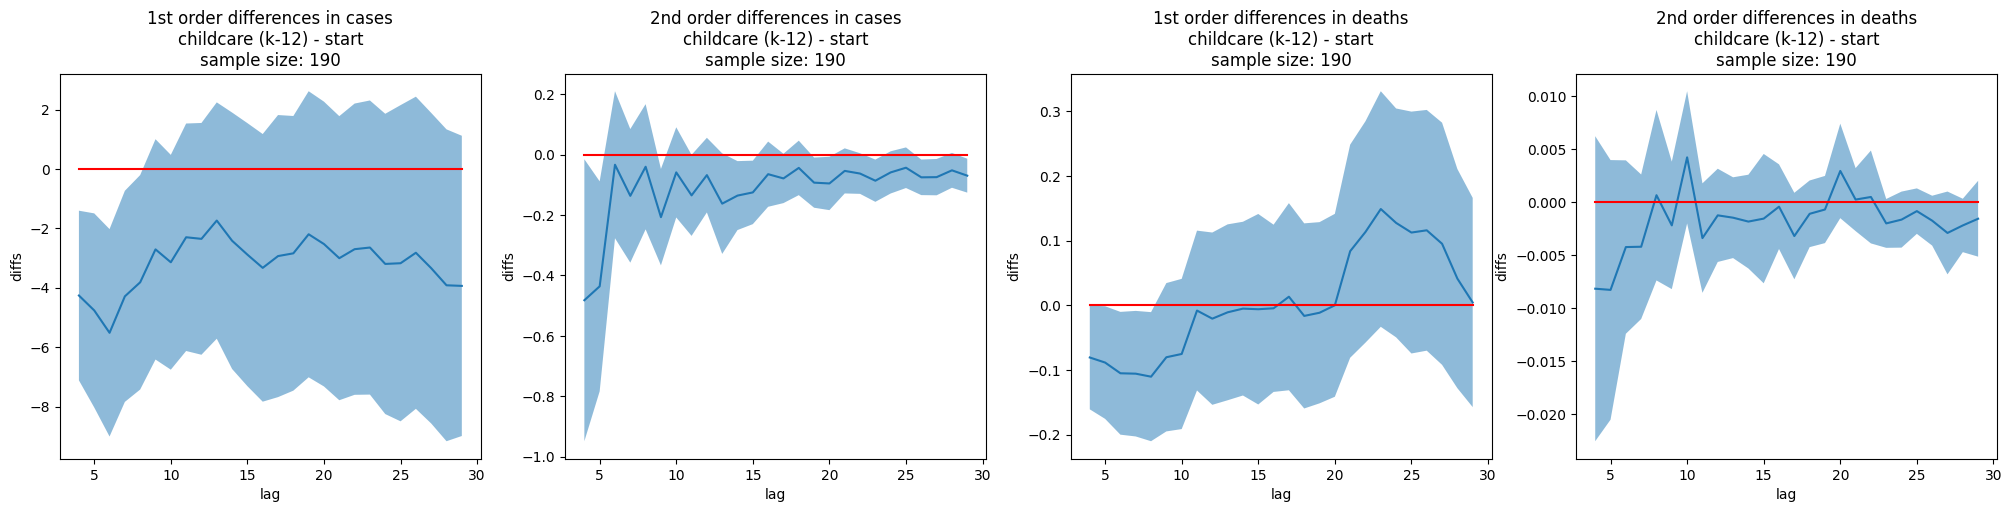

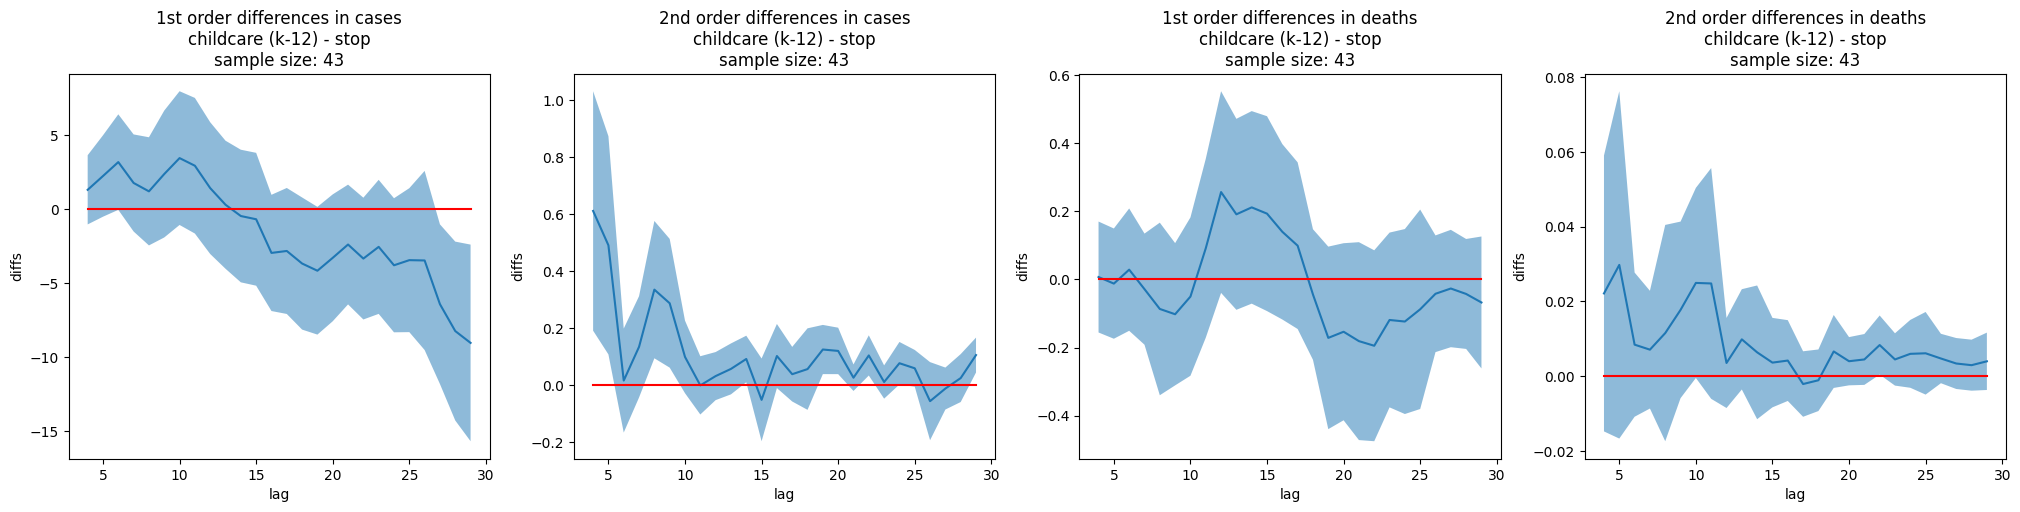

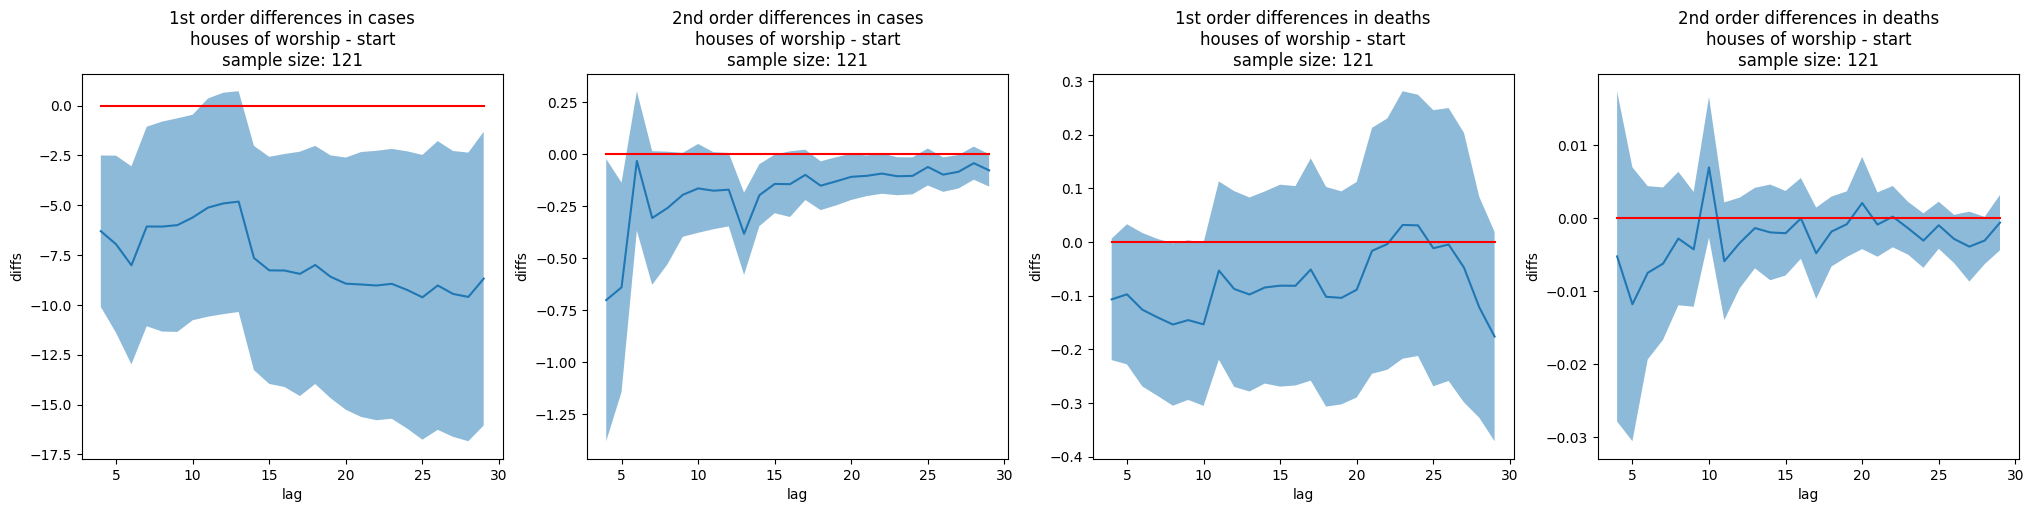

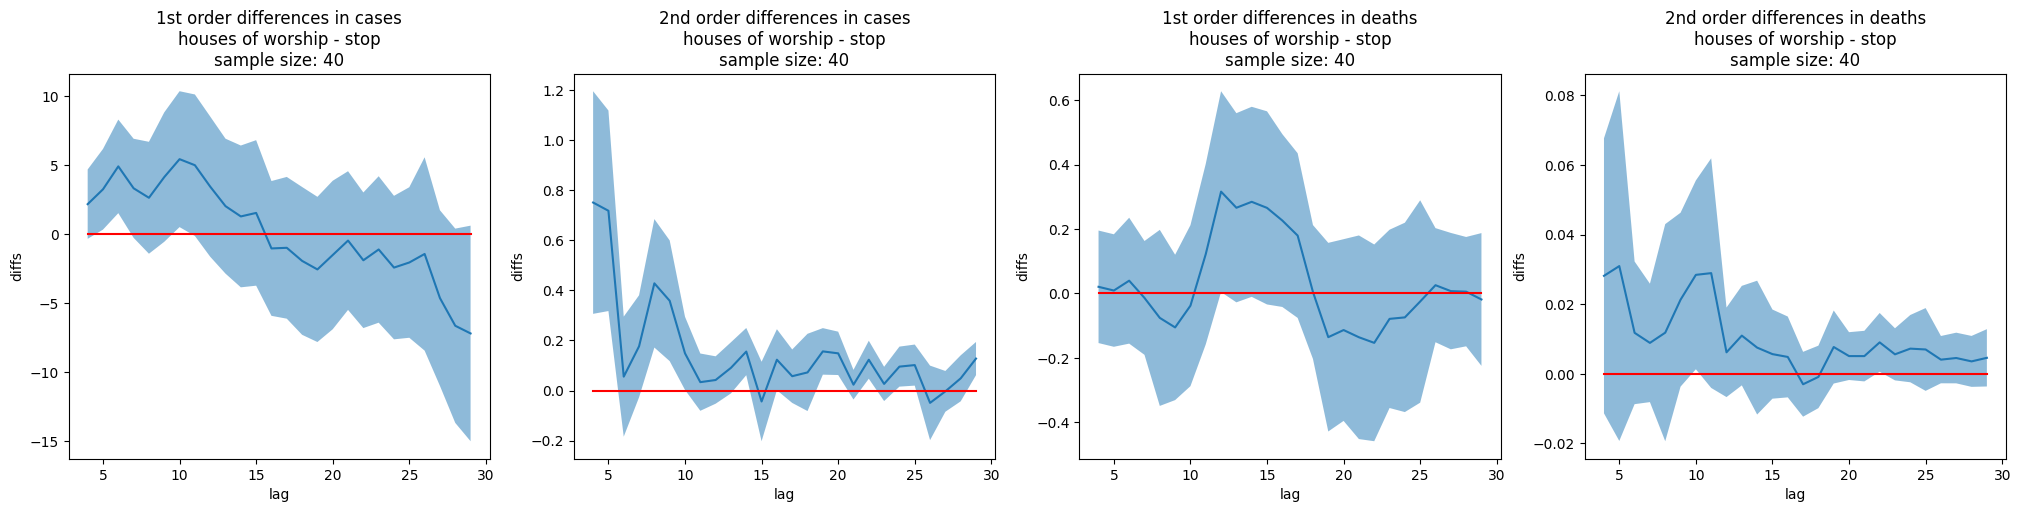

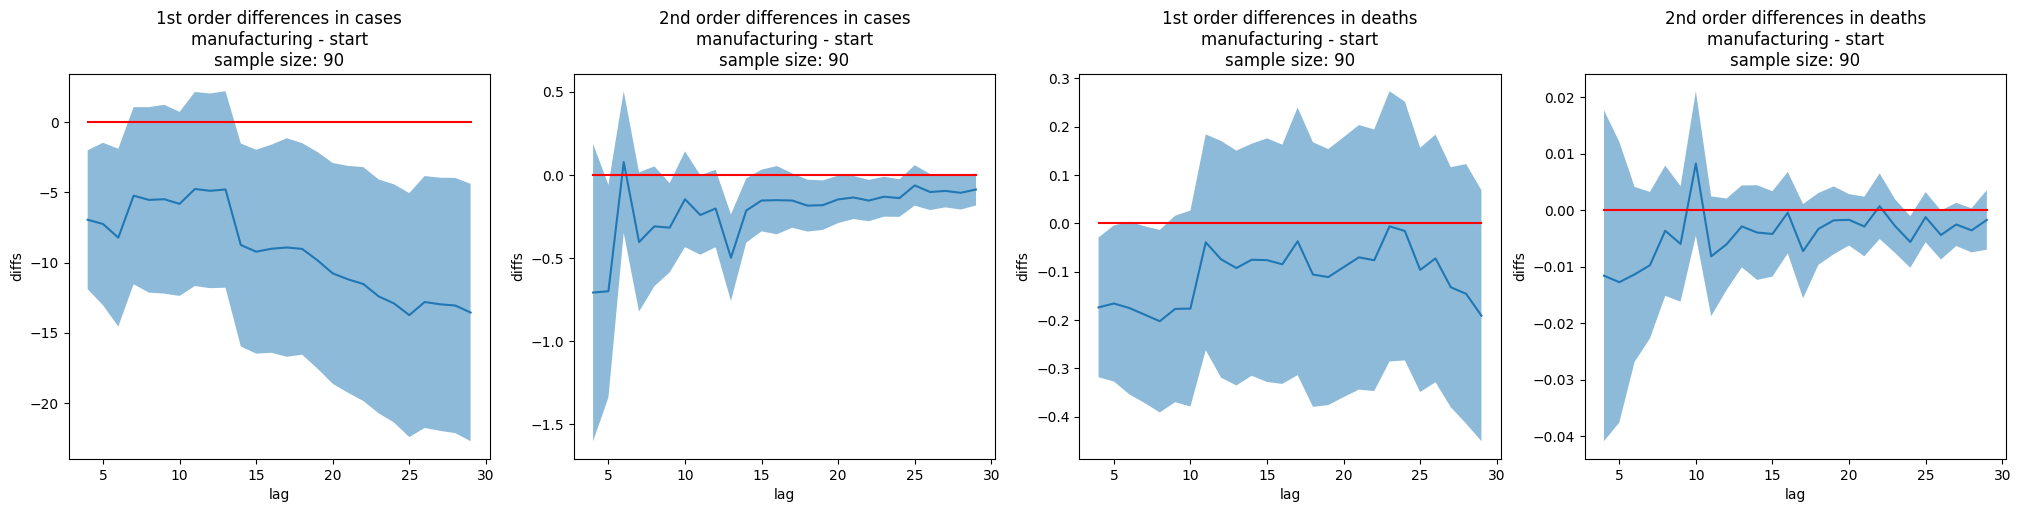

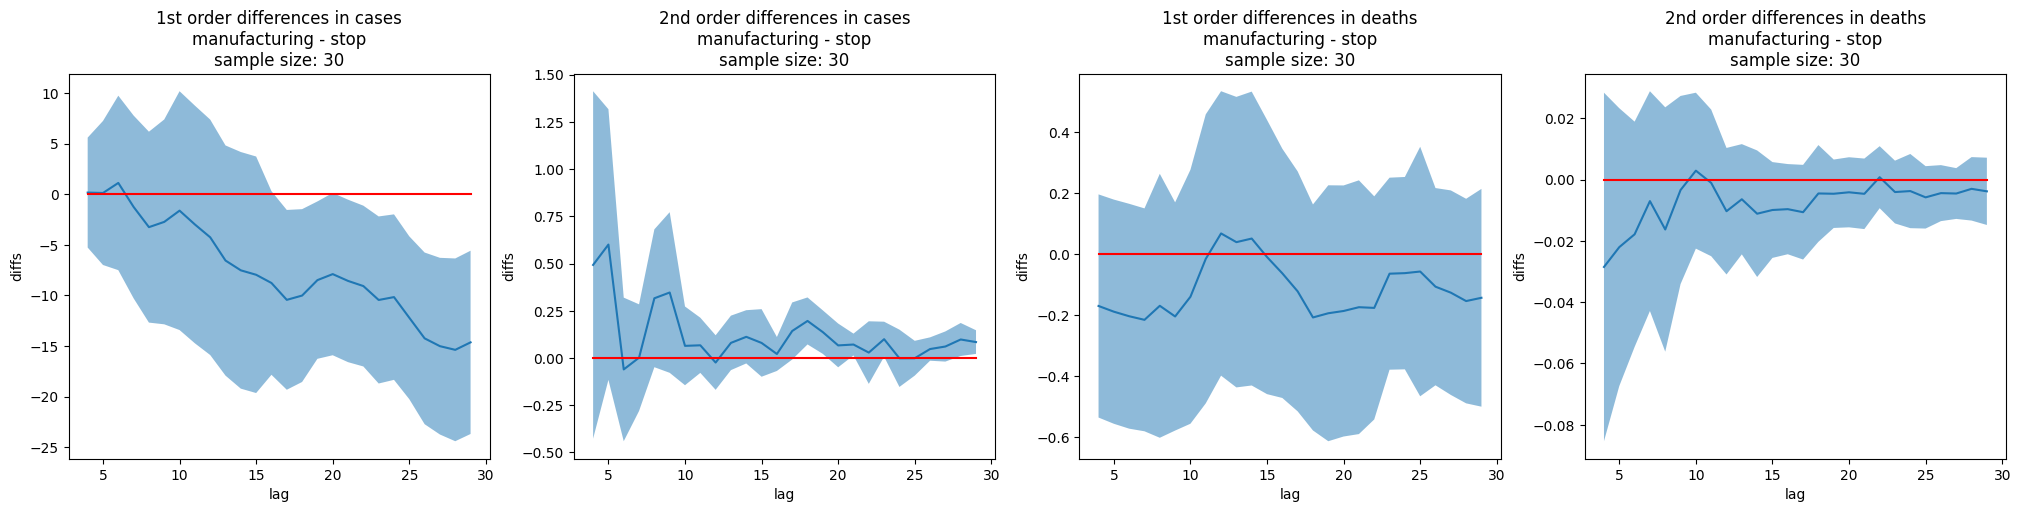

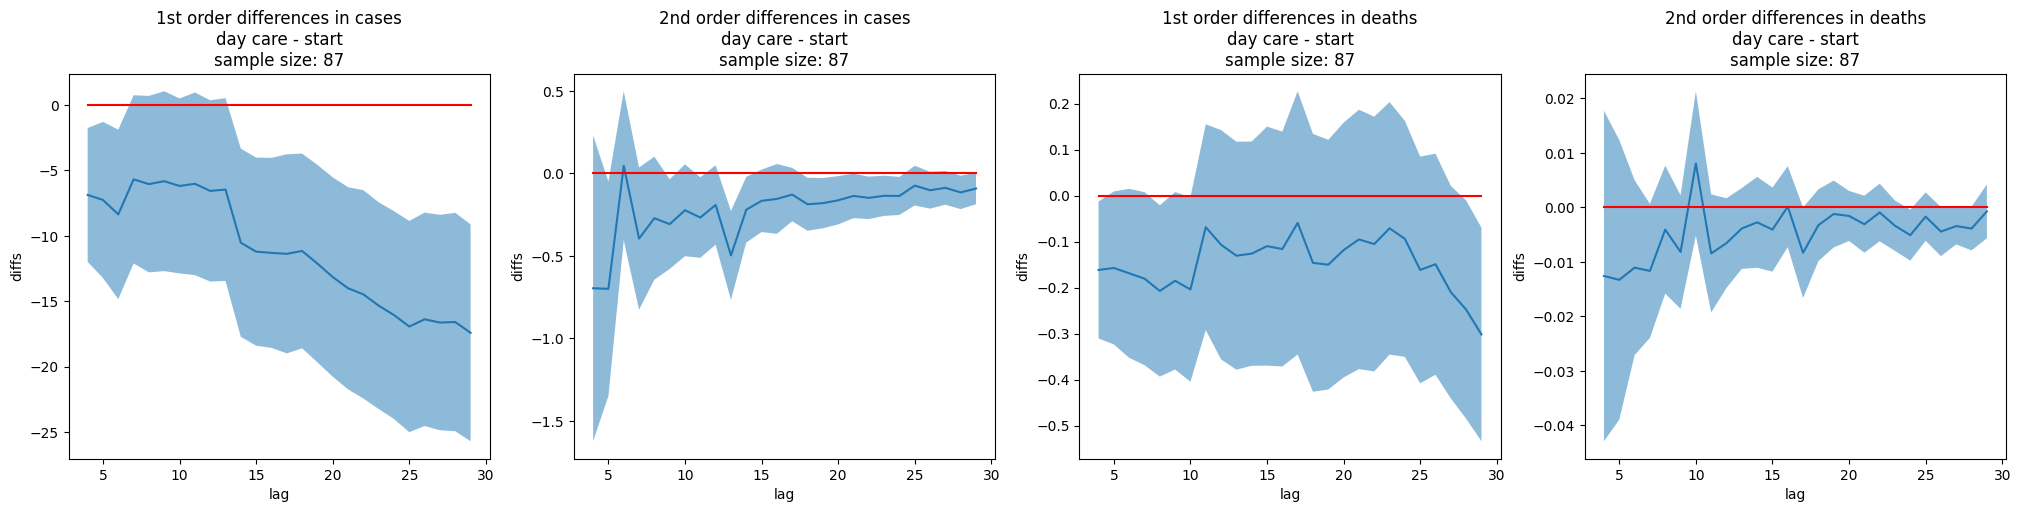

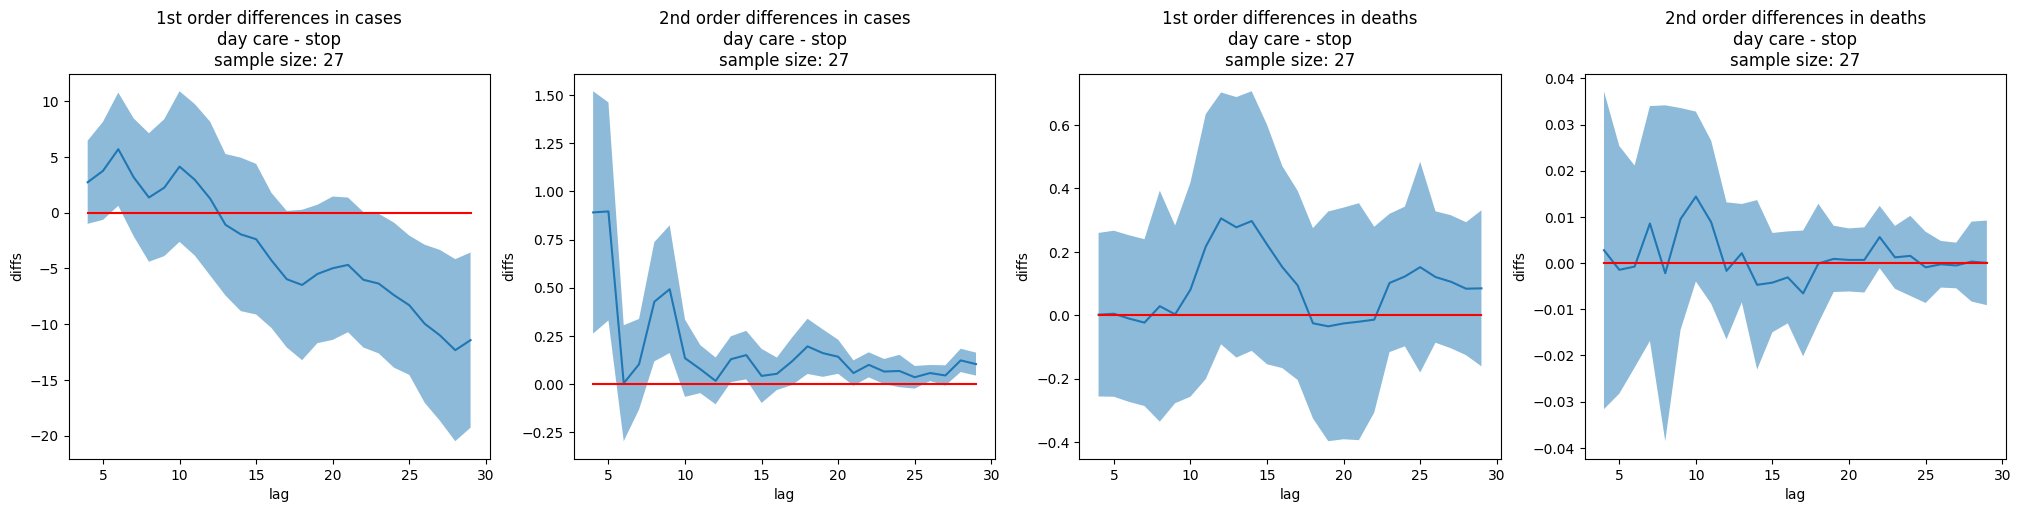

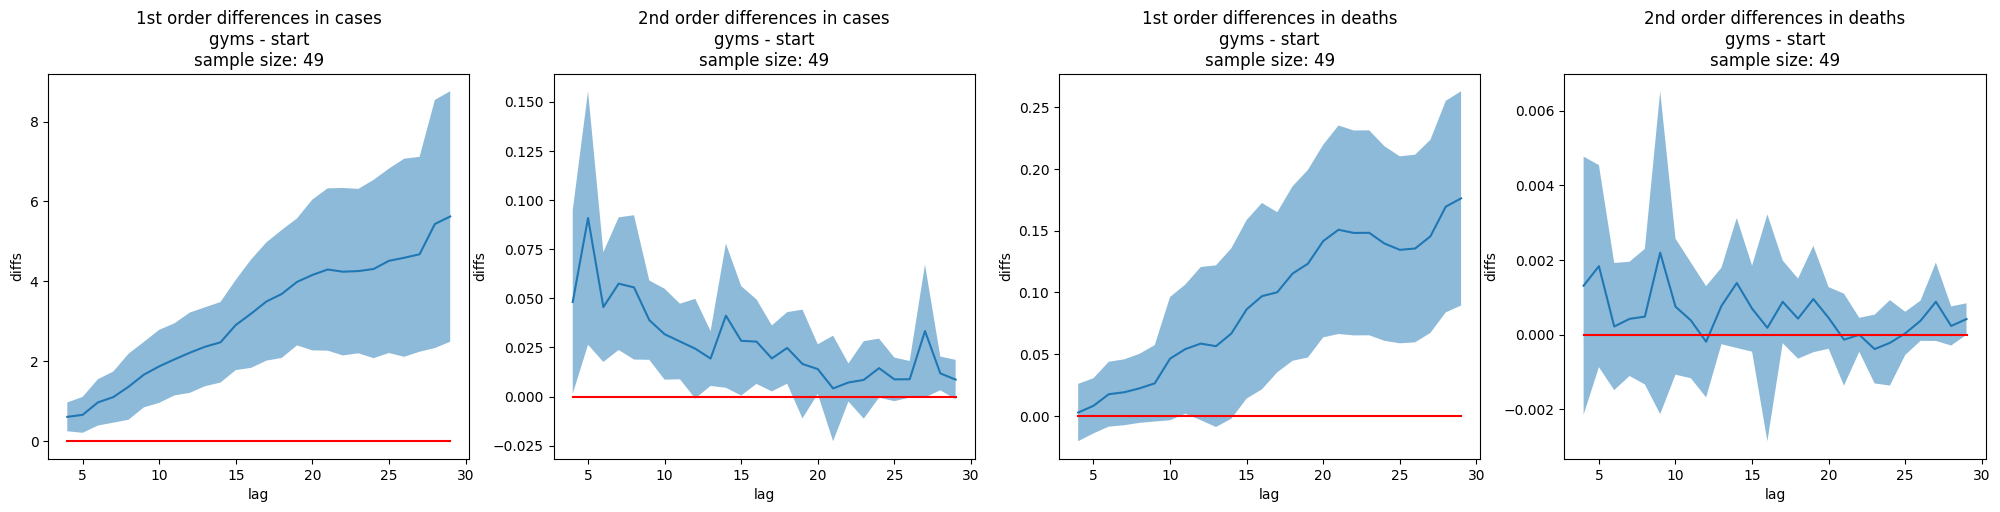

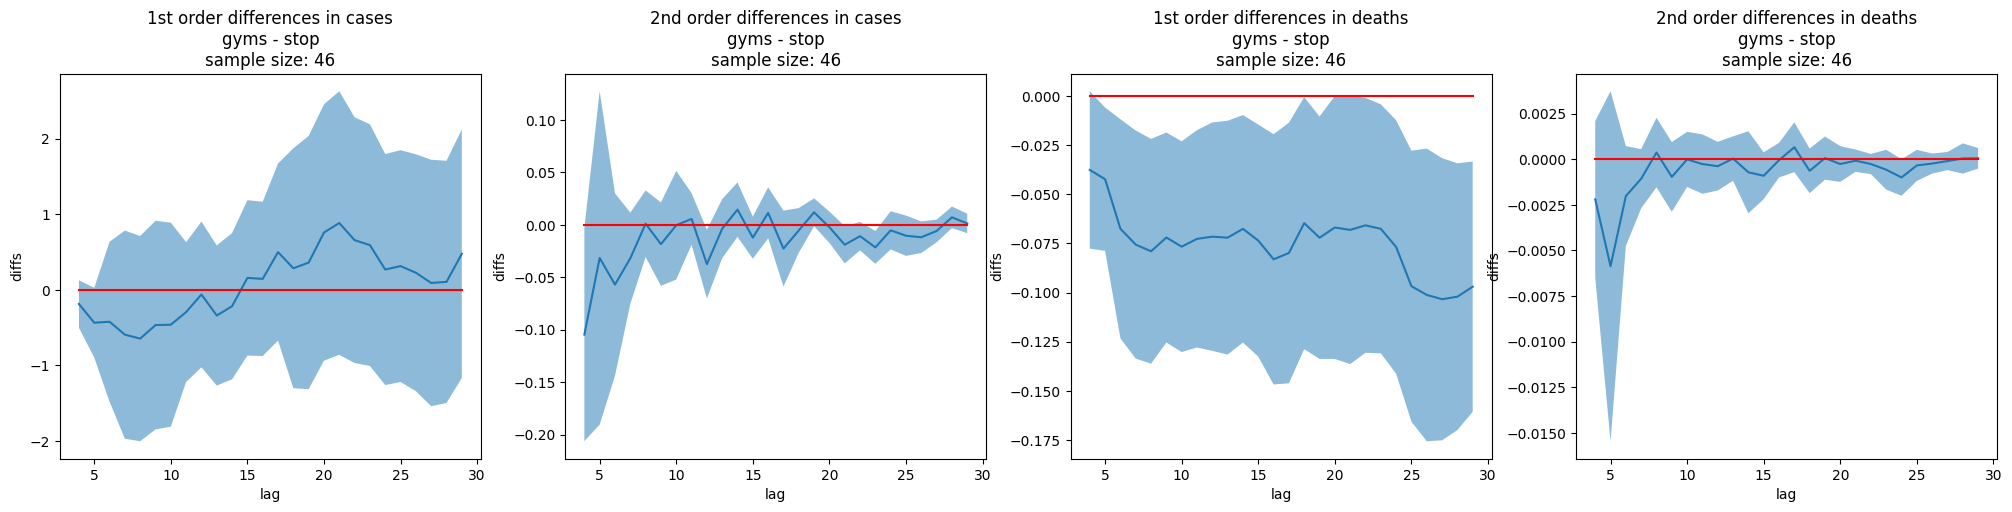

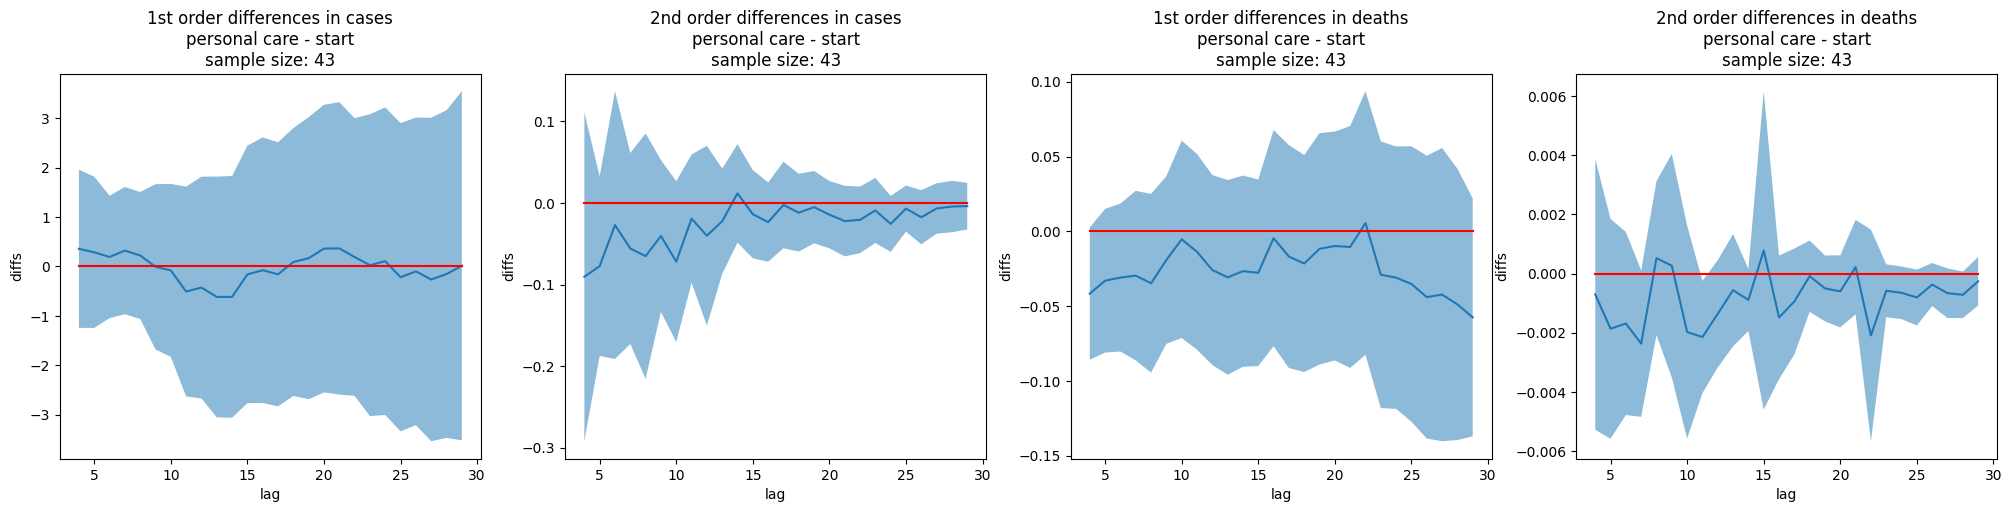

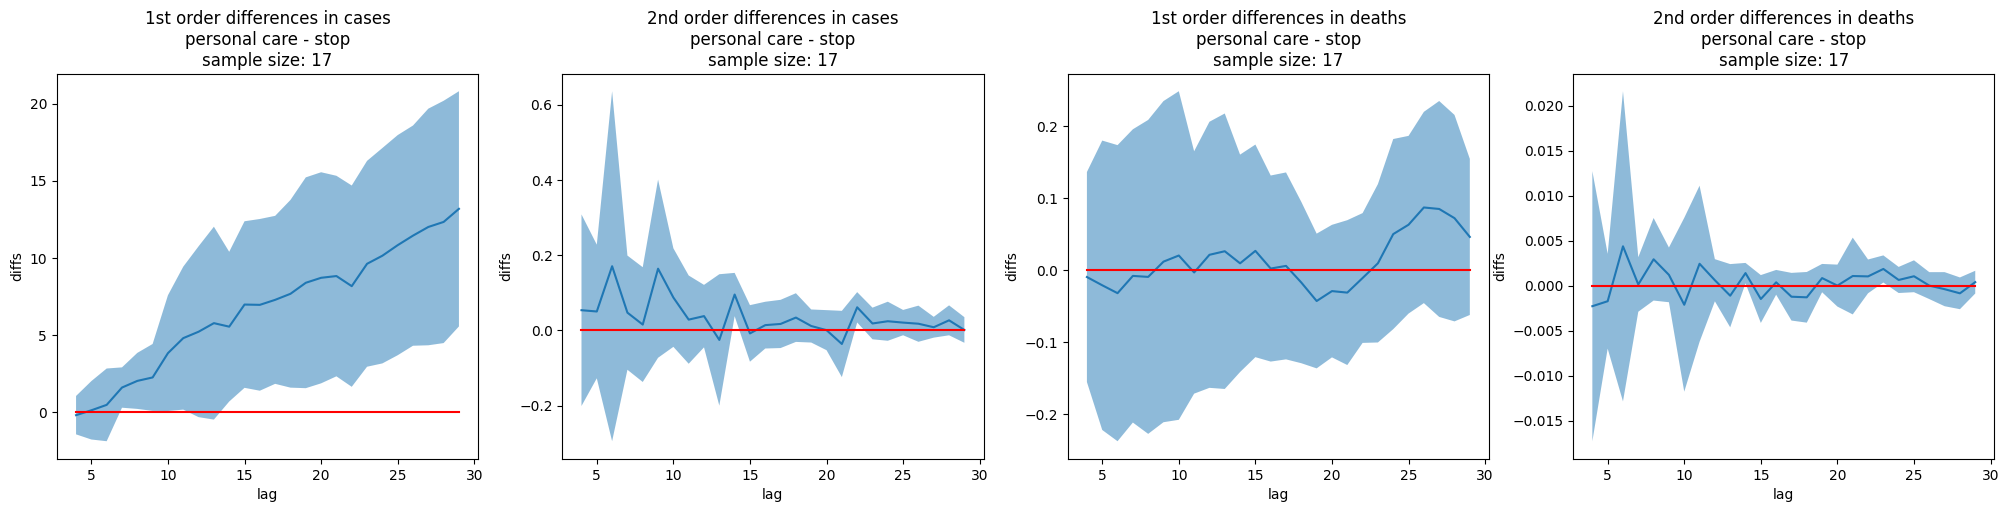

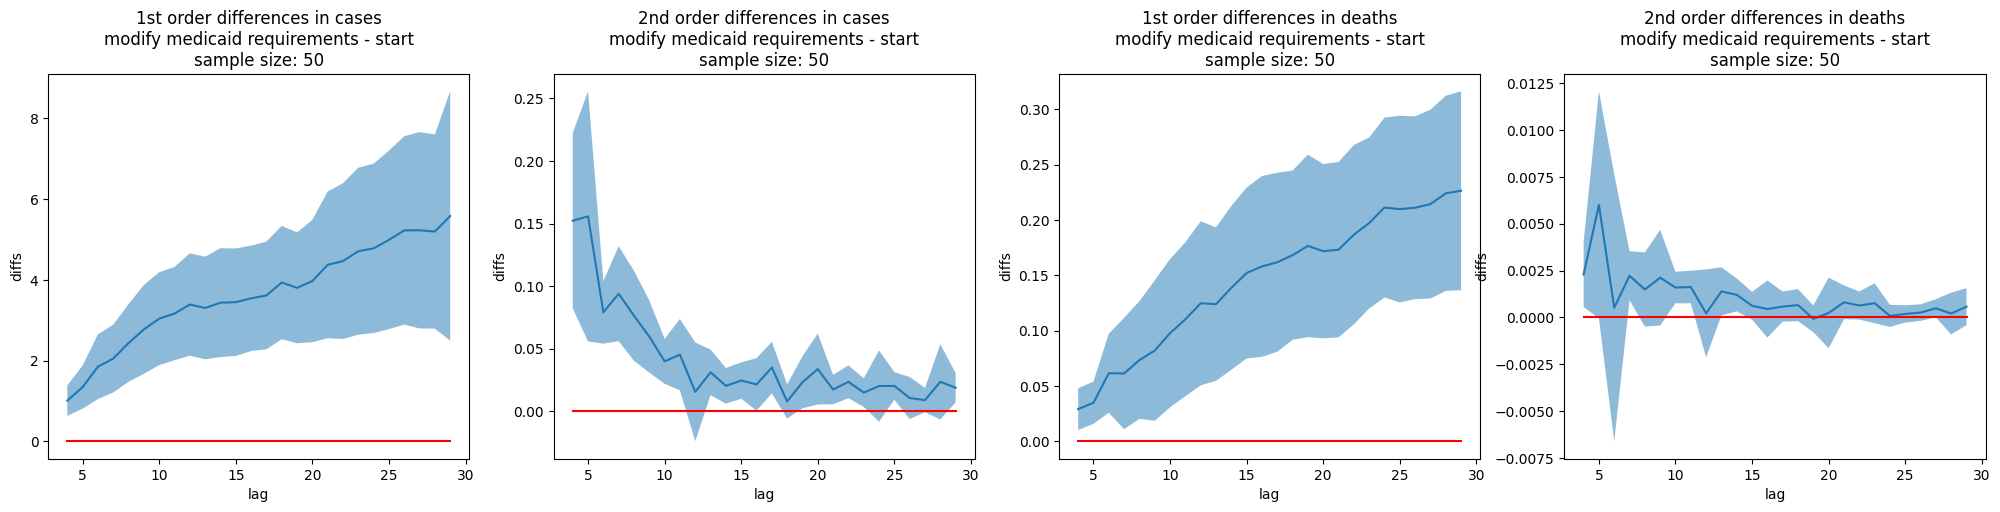

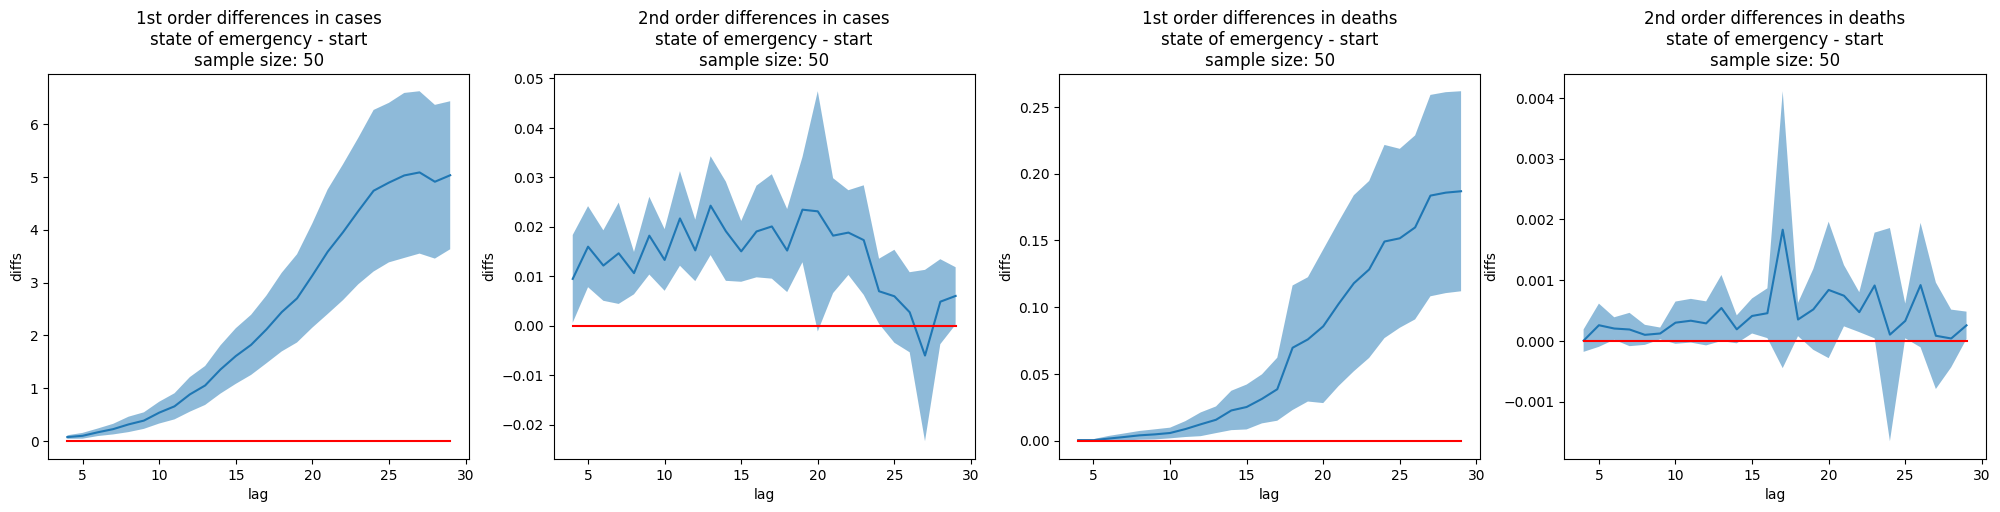

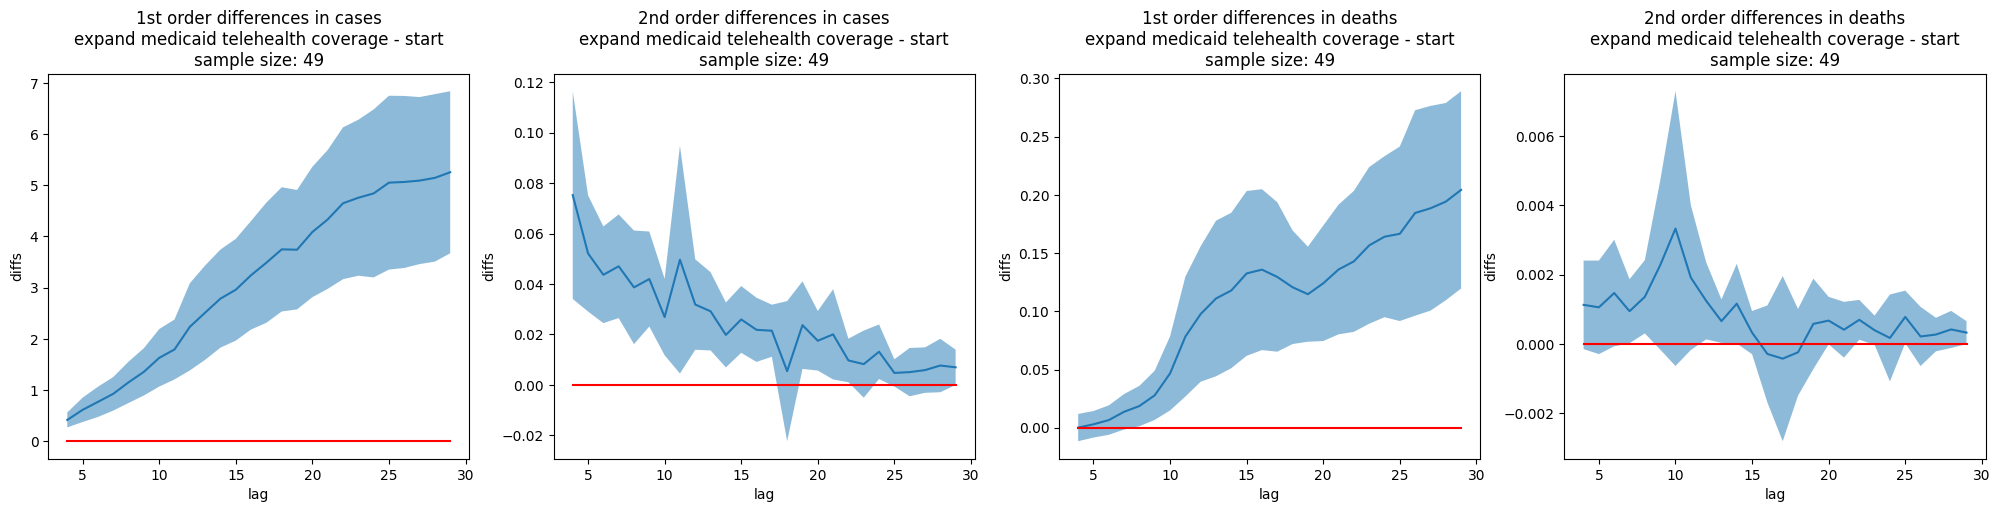

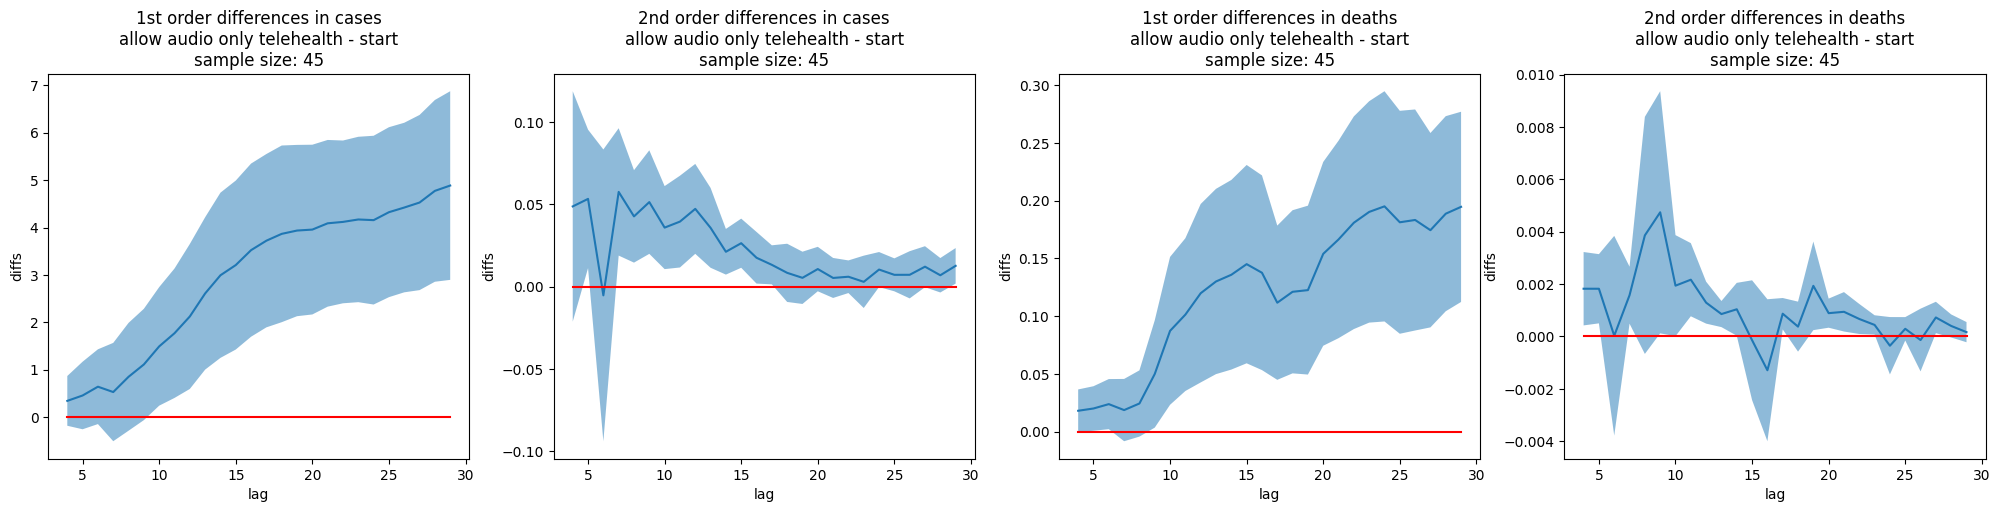

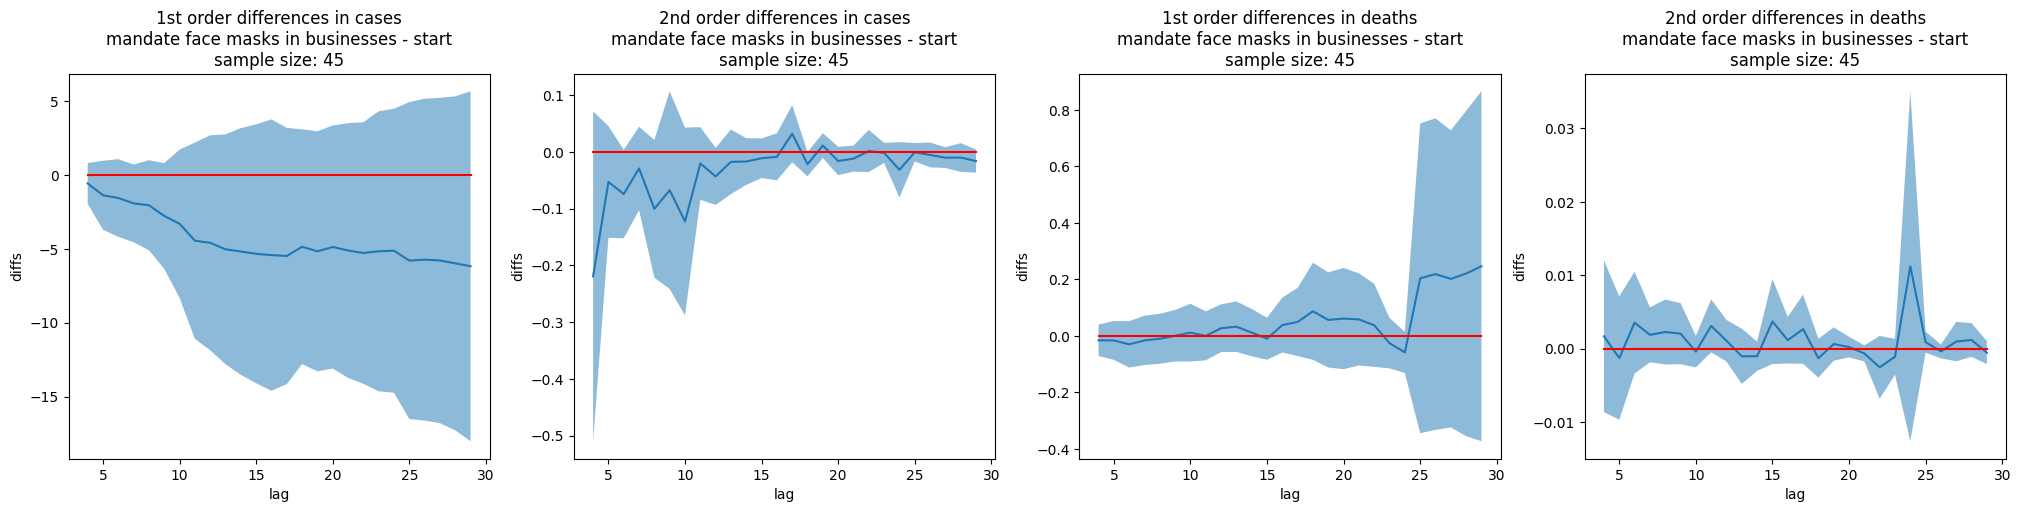

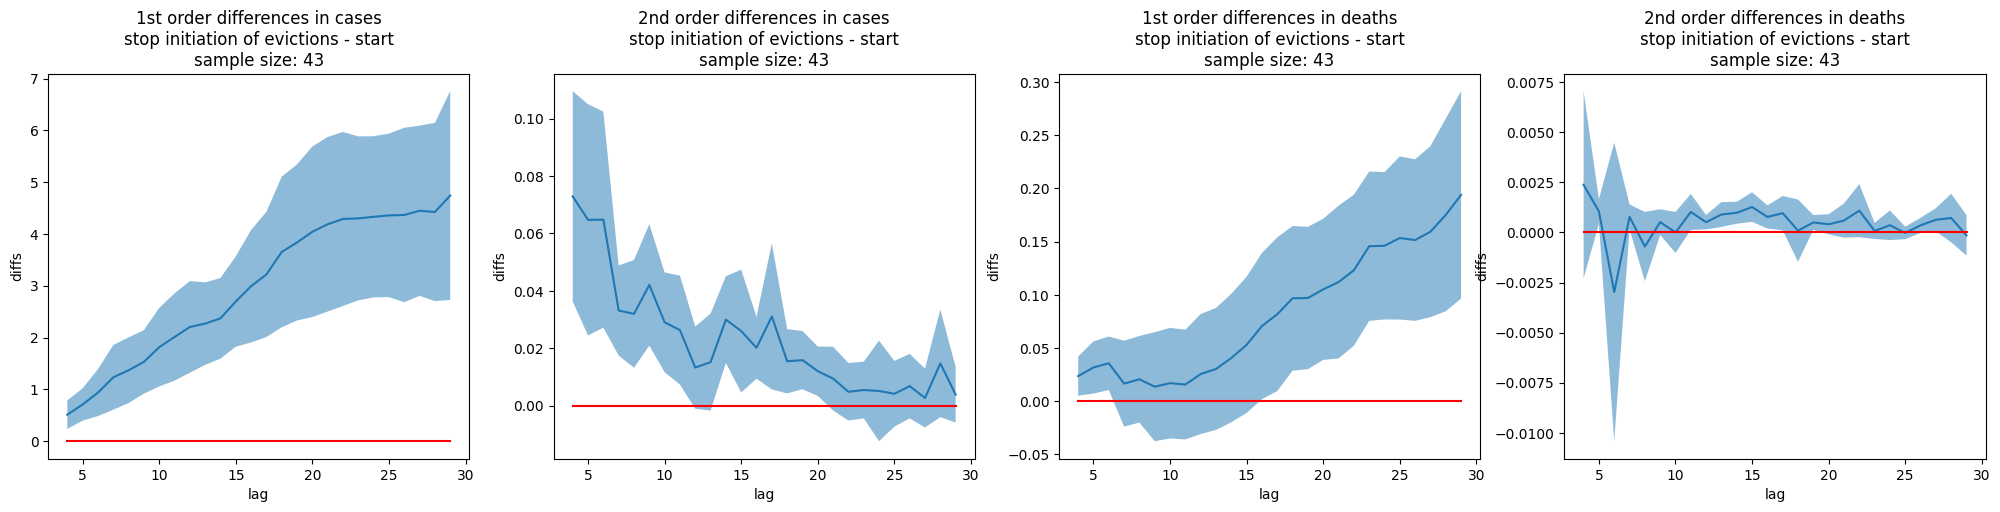

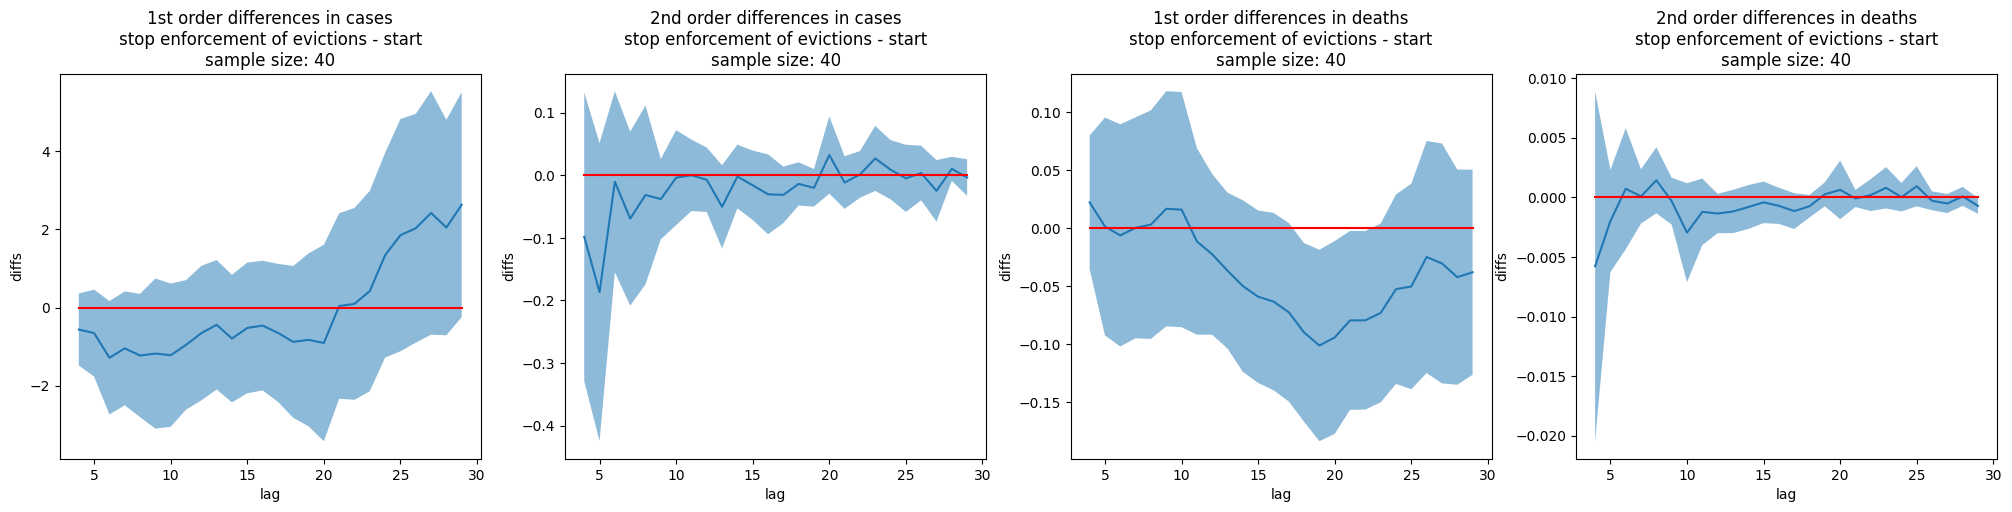

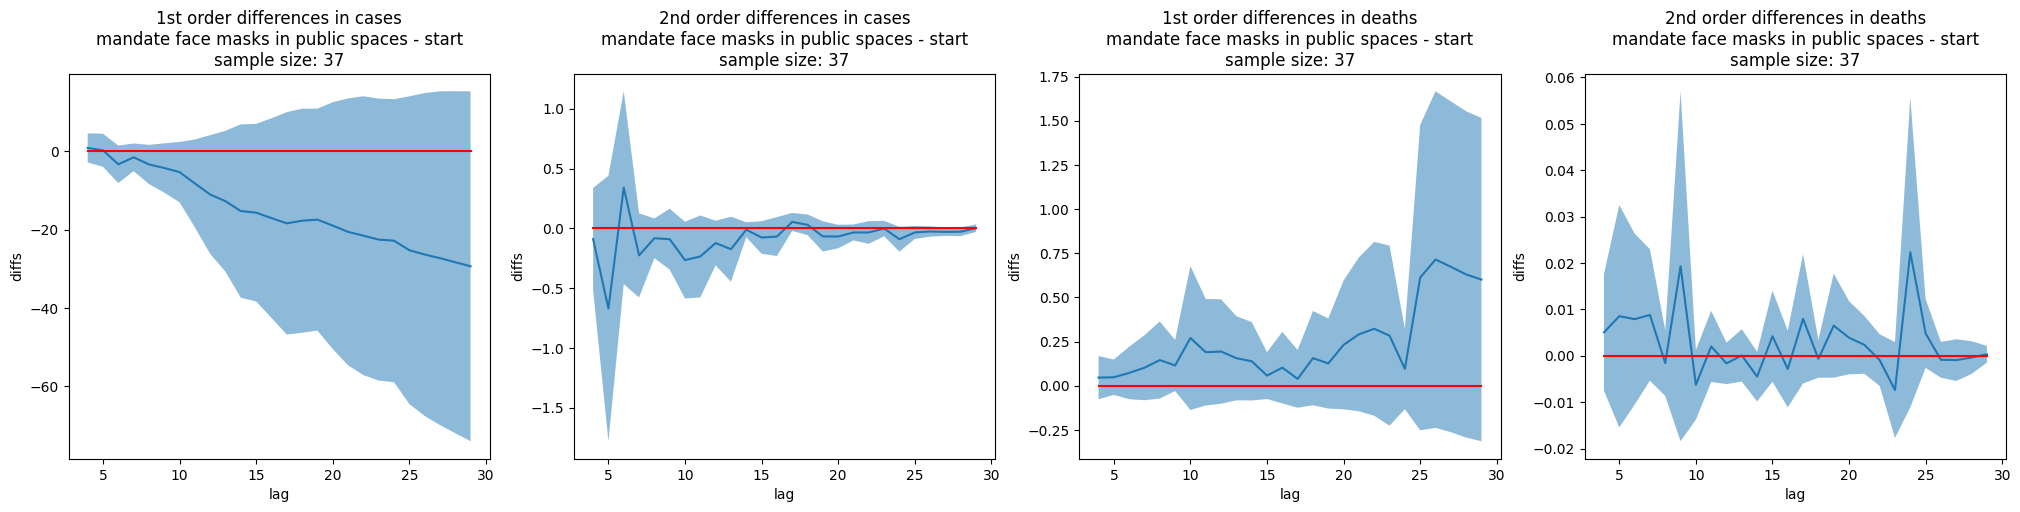

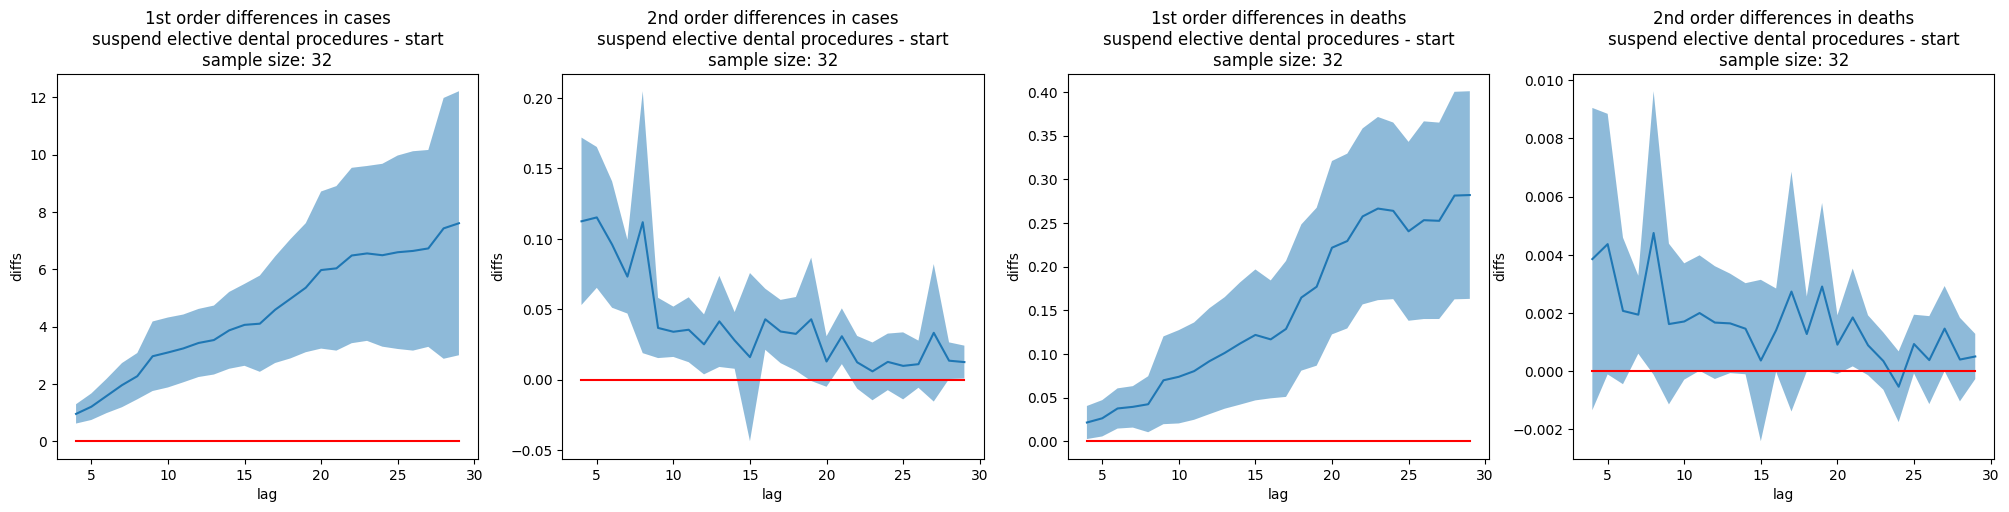

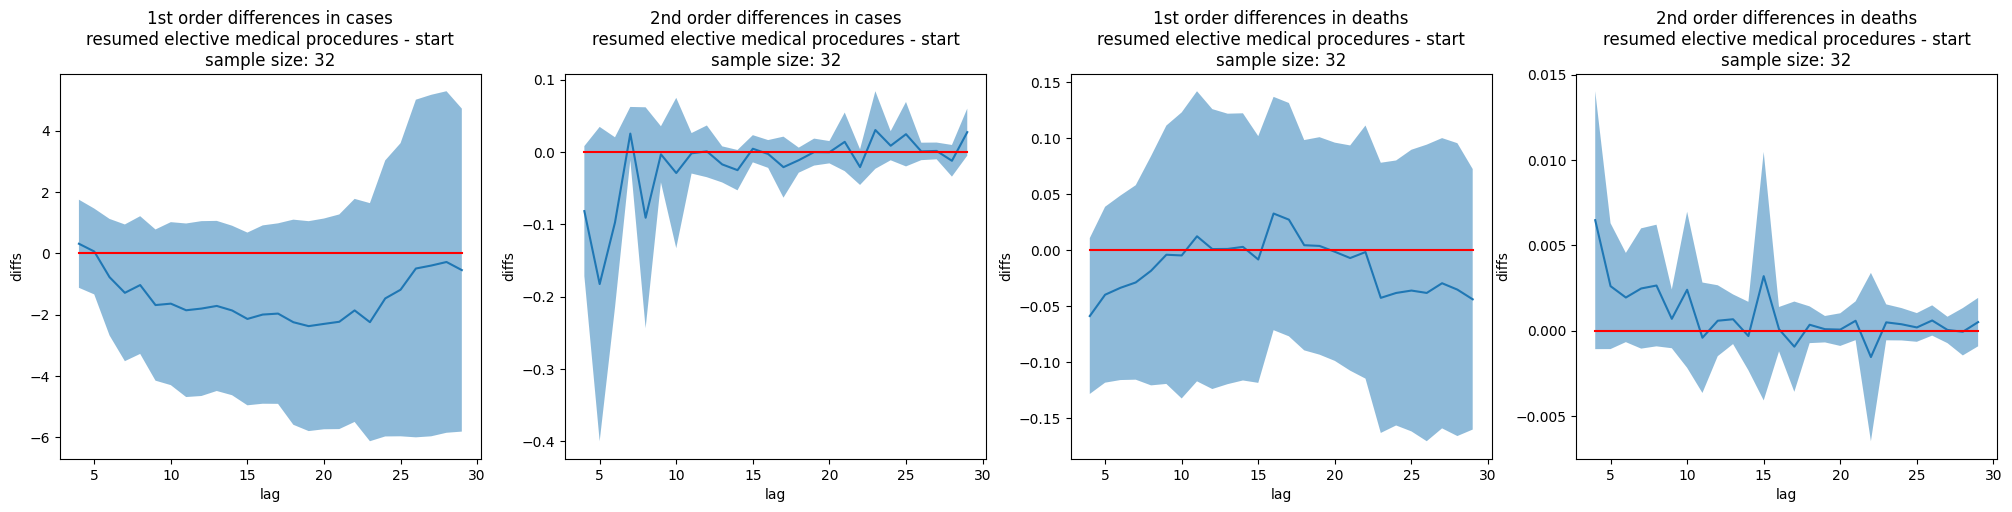

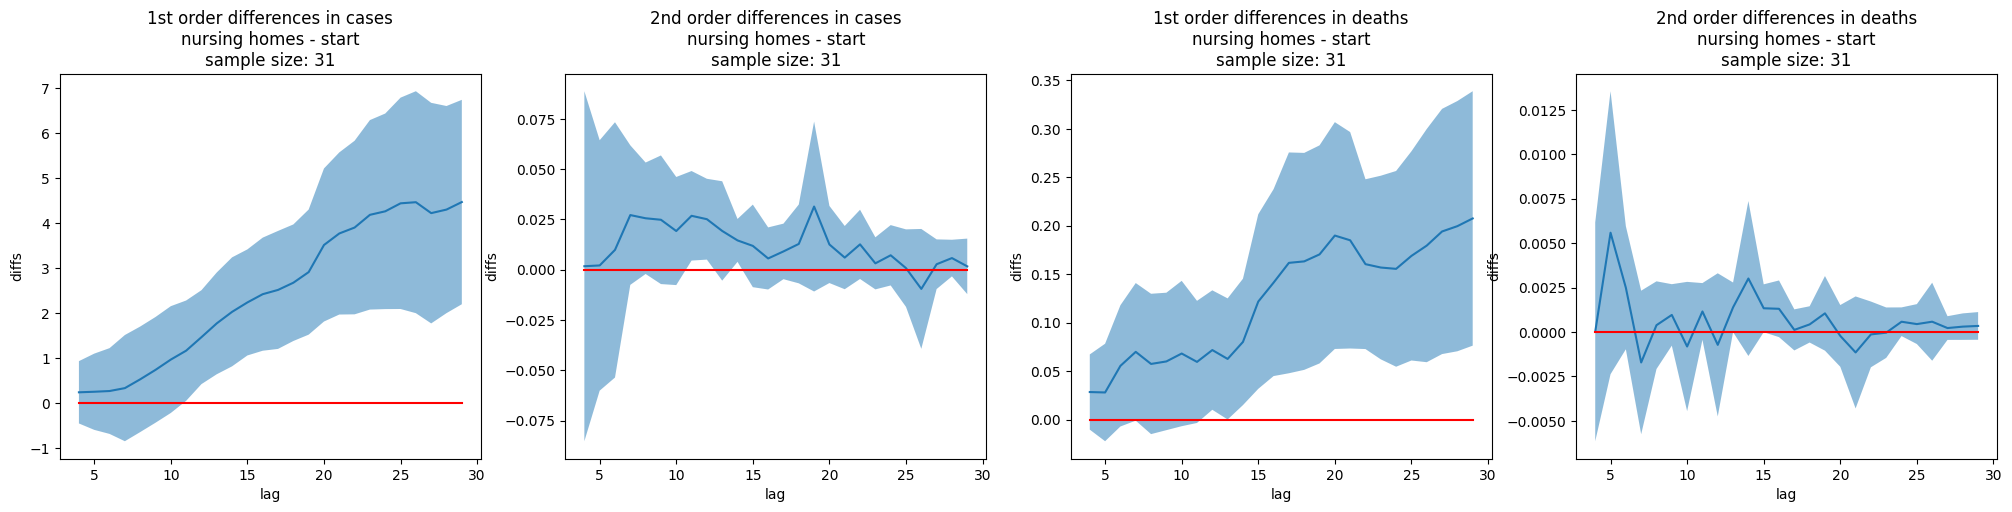

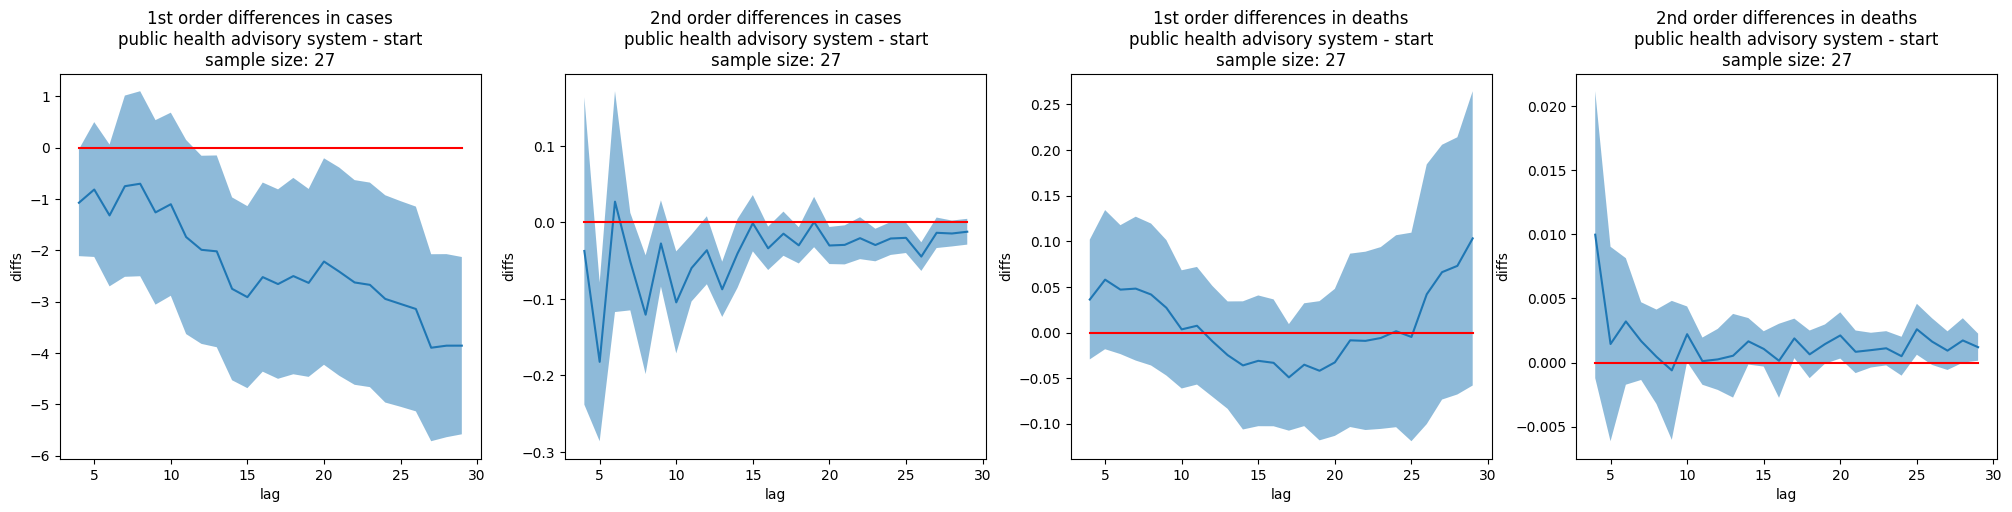

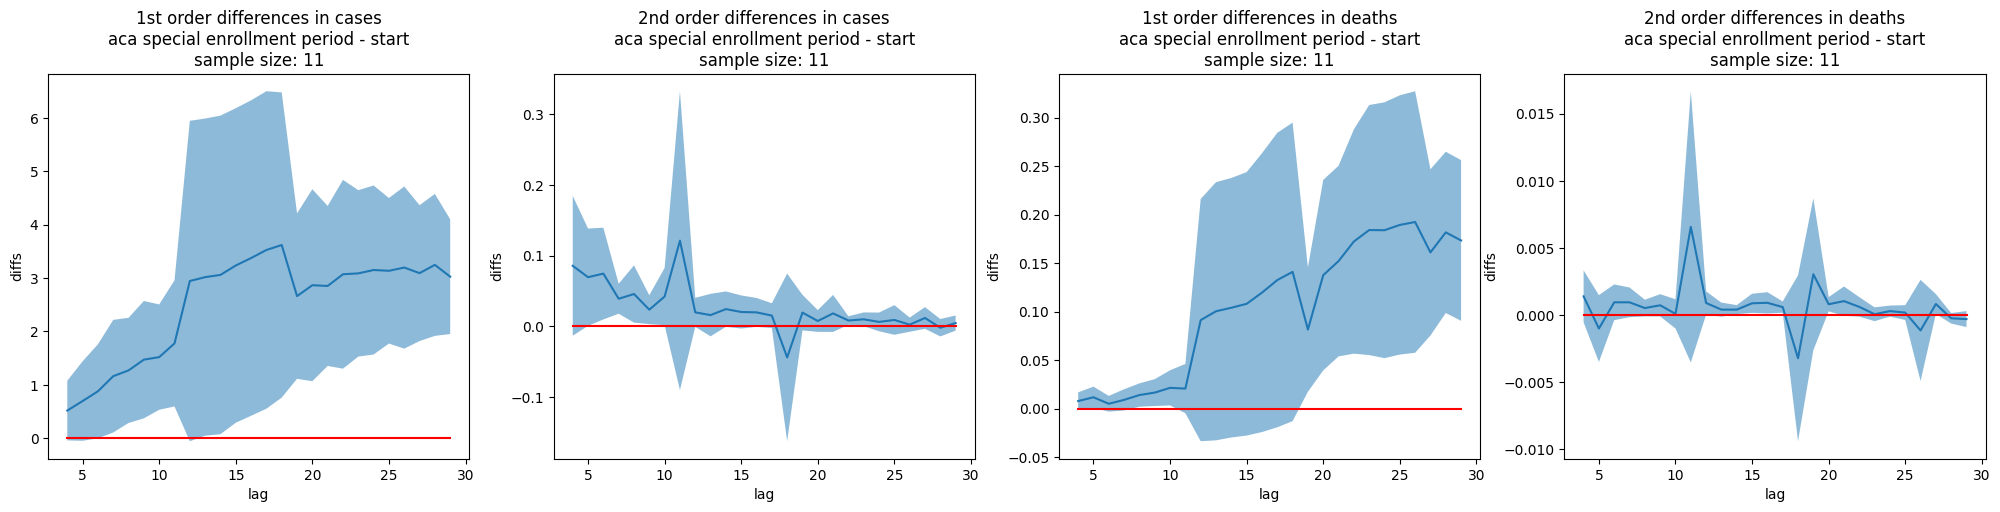

In [25]:
policy_order = stats[['policy', 'sample_size']].groupby(['policy']).sum().reset_index().sort_values(by='sample_size', ascending=False)['policy']

for policy_type in policy_order:
    for start_stop in ['start', 'stop']:
        policy = policy_type + ' - ' + start_stop
    
        data = stats[stats['full_policy'] == policy].sort_values(by='lag')
        if len(data) == 0:
            continue
            
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))
        
        for j, key in enumerate(['case_1st_order', 'case_2nd_order', 'death_1st_order', 'death_2nd_order']):
            axes[j].plot(data['lag'],
                                    data[f'{key}_mean'])
            axes[j].plot(data['lag'],
                                    [0]*len(data), c='r')
                
            axes[j].fill_between(data['lag'],
                             data[f'{key}_ci_lower'],
                             data[f'{key}_ci_upper'],
                             alpha = 0.5) 
            axes[j].set_xlabel("lag")
            axes[j].set_ylabel("diffs")
            title = f"{key.split('_')[1]} order differences in {key.split('_')[0]}s"
            axes[j].set_title(title + "\n" + policy + "\nsample size: " + str(data['sample_size'].values[0]))

